In [1]:
pip install xgboost --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install category_encoders

In [3]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [4]:
# --- Fonction pour le projet --- #

def cross_valid(X_train, y_train, X_test, y_test, preprocessor):
    '''
    Fonction pour effectuer une cross-validation sur plusieurs modèles et évaluer 
    leurs performances sur les données d'entraînement et de test.
    '''
    
    # Liste des modèles à tester
    liste = [
        DummyRegressor(strategy='mean'),   # Modèle de référence (baseline) : prédit toujours la moyenne des cibles
        LinearRegression(),               # Régression linéaire simple sans régularisation
        Ridge(),                          # Régression linéaire avec régularisation L2 pour éviter les coefficients trop grands
        Lasso(max_iter=20000, alpha = 100), # Régression linéaire avec régularisation L1 pour réduire à zéro les coefficients inutiles
        ElasticNet(max_iter=20000, alpha = 100), # Combine L1 et L2 pour un compromis entre parcimonie et limitation des coefficients
        RandomForestRegressor(random_state=42),  # Forêt aléatoire, basée sur des arbres de décision, efficace pour les relations complexes
        KNeighborsRegressor(),            # K-Nearest Neighbors : utilise la proximité des données pour faire des prédictions
        SVR(),                            # Support Vector Regressor : utilise des marges maximales pour la régression
        XGBRegressor()                    # Extreme Gradient Boosting : méthode puissante d'ensemble basée sur des arbres optimisés
    ]
    
    # Initialisation des listes pour stocker les résultats des différentes métriques pendant la validation croisée
    RMSE = []       # Root Mean Squared Error : racine de l'erreur quadratique moyenne (CV)
    R2 = []         # Coefficient de détermination R² (CV)
    MAE = []        # Mean Absolute Error : erreur absolue moyenne (CV)
    MedAE = []      # Median Absolute Error : erreur absolue médiane (CV)
    FIT_TIME = []   # Temps moyen d'entraînement pendant la cross-validation
    SCORE_TIME = [] # Temps moyen pour effectuer les prédictions pendant la cross-validation
    
    # Initialisation des listes pour les performances sur le jeu de test
    TEST_RMSE = []  # Erreur quadratique moyenne (racine) sur le jeu de test
    TEST_R2 = []    # Coefficient de détermination R² sur le jeu de test
    TEST_MAE = []   # Erreur absolue moyenne sur le jeu de test
    TEST_MedAE = [] # Erreur absolue médiane sur le jeu de test

    # Boucle pour tester chaque modèle dans la liste
    for model in liste:
        # Création d'un pipeline : 
        # - Applique d'abord le préprocesseur aux données (standardisation/encodage)
        # - Ensuite, ajuste le modèle spécifié
        pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
        
        # Validation croisée (CV) pour évaluer les performances sur plusieurs partitions des données d'entraînement
        score = cross_validate(
            pipe,                         # Pipeline combinant préprocesseur et modèle
            X_train, y_train,             # Données d'entraînement
            cv=5,                         # Nombre de partitions (5-fold cross-validation)
            scoring=(                     # Métriques d'évaluation
                'neg_root_mean_squared_error',  # RMSE (retourné négatif par sklearn, d'où le besoin d'inverser le signe)
                'r2',                          # Coefficient de détermination R²
                'neg_mean_absolute_error',     # MAE (retourné négatif par sklearn)
                'neg_median_absolute_error'    # MedAE (retourné négatif par sklearn)
            ),
            return_train_score=False      # Ne pas inclure les scores sur le jeu d'entraînement
        )
        
        # Moyenne des résultats obtenus sur les 5 partitions (folds)
        rmse = score['test_neg_root_mean_squared_error'].mean()  # Moyenne des RMSE
        r2 = score['test_r2'].mean()                            # Moyenne des R²
        mae = score['test_neg_mean_absolute_error'].mean()      # Moyenne des MAE
        medae = score['test_neg_median_absolute_error'].mean()  # Moyenne des MedAE
        fit_time = score['fit_time'].mean()                     # Temps moyen d'entraînement
        score_time = score['score_time'].mean()                 # Temps moyen de prédiction

        # Entraîner le pipeline complet sur tout le jeu d'entraînement
        pipe.fit(X_train, y_train)
        
        # Faire des prédictions sur le jeu de test
        y_pred_test = pipe.predict(X_test)
        
        # Calcul des métriques sur le jeu de test
        test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)  # RMSE sur le test
        test_r2 = r2_score(y_test, y_pred_test)                            # R² sur le test
        test_mae = mean_absolute_error(y_test, y_pred_test)                # MAE sur le test
        test_medae = median_absolute_error(y_test, y_pred_test)            # MedAE sur le test

        # Stocker les résultats dans les listes correspondantes
        RMSE.append(-rmse)  # RMSE, inversé pour avoir une valeur positive
        R2.append(r2)       # Coefficient R²
        MAE.append(-mae)    # MAE, inversé pour avoir une valeur positive
        MedAE.append(-medae)# MedAE, inversé pour avoir une valeur positive
        FIT_TIME.append(fit_time)       # Temps moyen d'entraînement
        SCORE_TIME.append(score_time)   # Temps moyen de prédiction
        TEST_RMSE.append(test_rmse)     # RMSE sur le jeu de test
        TEST_R2.append(test_r2)         # R² sur le jeu de test
        TEST_MAE.append(test_mae)       # MAE sur le jeu de test
        TEST_MedAE.append(test_medae)   # MedAE sur le jeu de test
    
    # Création d'un tableau (DataFrame pandas) pour rassembler tous les résultats
    resultats = pd.DataFrame({
        'RMSE': RMSE,             # Résultats RMSE en CV
        'R2': R2,                 # Résultats R² en CV
        'MAE': MAE,               # Résultats MAE en CV
        'MedAE': MedAE,           # Résultats MedAE en CV
        'FIT_TIME': FIT_TIME,     # Temps moyen d'entraînement en CV
        'SCORE_TIME': SCORE_TIME, # Temps moyen de prédiction en CV
        'TEST_RMSE': TEST_RMSE,   # RMSE sur le jeu de test
        'TEST_R2': TEST_R2,       # R² sur le jeu de test
        'TEST_MAE': TEST_MAE,     # MAE sur le jeu de test
        'TEST_MedAE': TEST_MedAE  # MedAE sur le jeu de test
    })
    
    # Nommer les lignes pour indiquer quel modèle correspond à chaque ligne
    resultats.index = ['dum', 'lr', 'ridge', 'lasso', 'ElasticNet', 'RandomForest',
                       'KNR', 'SVR', 'XGBR']
    
    # Retourner le tableau des résultats pour analyse
    return resultats

def metrics_one(grid):
    res = pd.DataFrame(grid['grid_search'].cv_results_).sort_values('rank_test_r2')
    print('Meilleurs paramètres',grid['grid_search'].best_params_)
    print('Meilleur score RMSLE :',np.mean(res[res['rank_test_neg_mean_squared_log_error']==1]['mean_test_neg_mean_squared_log_error']))
    print('Meilleur score RMSE :',np.mean(res[res['rank_test_neg_root_mean_squared_error']==1]['mean_test_neg_root_mean_squared_error']))
    print('Meilleur score R2 :',grid['grid_search'].best_score_)
    print("Résultats des meilleurs paramètres :\n")
    display(res.loc[res['params']==grid['grid_search'].best_params_])
    
    return res

def bar_plot_compare(df, colonnes, neg=False):
    ''' Affiche des bar plots pour chaque variable renseignée en les triant en ordre croissant. '''
    fig, axes = plt.subplots(nrows=1, ncols=len(colonnes), figsize=(15, 6))  # Un seul rang de graphiques
    axes = axes.flatten()  # Transformer en liste pour faciliter l'itération

    for i, col in enumerate(colonnes):
        sorted_df = df.sort_values(by=col, ascending=True)  # Trier les valeurs
        
        if neg:
            sns.barplot(x=sorted_df["Modèle"], y=-1 * sorted_df[col], ax=axes[i])
        else:
            sns.barplot(x=sorted_df["Modèle"], y=sorted_df[col], ax=axes[i])
        
        axes[i].set_title(col)
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha="right")  # Rotation pour lisibilité

    plt.tight_layout(pad=3)
    plt.show()

    
def metrics_pred(y_true, y_pred):
    '''Calcule les métriques'''
    rmsle = mean_squared_log_error(y_true= y_true, y_pred=y_pred)
    r2 =  r2_score(y_true= y_true, y_pred=y_pred)
    res = pd.DataFrame({'RMSLE': rmsle,'R2':r2},index=[0])
    return res

#Fonction pour évaluer les performances
def metrics_pred(y_true, y_pred):
    res = {
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R²": r2_score(y_true, y_pred)
    }
    return pd.DataFrame([res])  # Retourne un DataFrame pour affichage clair

#Fonction pour entraîner et tester un modèle
def test_model(model, model_name, X_train, y_train, X_test, y_test, preprocessor):
    """
    Fonction pour entraîner un modèle, prédire et évaluer les performances sur le jeu d'entraînement et de test.
    """
    #Création du pipeline avec preprocessing
    pipeline = Pipeline([
        ('preprocessor', preprocessor),  # Appliquer le preprocessing
        ('model', model)  # Modèle ML
    ])

    #Entraînement du modèle
    pipeline.fit(X_train, y_train)

    #Prédictions
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    #Évaluation des performances
    res_train = metrics_pred(y_train, y_train_pred)
    res_test = metrics_pred(y_test, y_test_pred)

    print(f"Résultats pour {model_name} :")
    print("Comparaison des performances sur le jeu d'entraînement :")
    display(res_train)
    print("Comparaison des performances sur le jeu de test :")
    display(res_test)

    return res_train, res_test

def grid_search_cv(model, params, preprocessor):
    """
    Crée un pipeline avec un préprocesseur et une recherche d'hyperparamètres via GridSearchCV.

    Args:
        model: Modèle de régression à tester.
        params: Dictionnaire des hyperparamètres à tester.

    Returns:
        Un pipeline entraînable contenant le modèle optimisé.
    """
    
    grid = Pipeline([
        ('preprocessor', preprocessor),  #Préprocessor passé en paramètre
        ('grid_search', GridSearchCV(
            TransformedTargetRegressor(regressor=model, func=np.log, inverse_func=np.exp),
            param_grid=params,
            cv=5,
            scoring=('neg_root_mean_squared_error', 'r2', 'neg_mean_absolute_error', 
                     'neg_median_absolute_error', 'neg_mean_squared_log_error'),
            return_train_score=True,
            refit='r2',
            n_jobs=-1
        ))
    ])
    
    return grid

def metric(grid, X_test, y_test):
    """
    Affiche et retourne les résultats du GridSearchCV pour l'entraînement et le test.

    Args:
        grid: Pipeline contenant le GridSearchCV.
        X_test: Données de test.
        y_test: Cibles de test.

    Returns:
        Résultats du GridSearchCV sous forme de DataFrame.
    """
    
    res = pd.DataFrame(grid['grid_search'].cv_results_).sort_values('rank_test_r2')
    
    print(" Meilleurs paramètres :", grid['grid_search'].best_params_)
    print(" Meilleur score RMSE :", np.mean(res[res['rank_test_neg_root_mean_squared_error'] == 1]['mean_test_neg_root_mean_squared_error']))
    print(" Meilleur score R2 :", grid['grid_search'].best_score_)
    
    print("\n Évaluation sur le jeu de test :")
    y_pred = grid.predict(X_test)
    
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    
    print(f" MAE (Test) : {mean_absolute_error(y_test, y_pred)}")
    print(f" RMSE (Test) : {np.sqrt(mean_squared_error(y_test, y_pred))}")
    print(f" R² (Test) : {r2_score(y_test, y_pred)}")
    
    return res

# Prédiction et modélisation pour la variable TotalGHGEmissions

## Sommaire 

    1. Préparation des données
    2. Optimisation modèles
    3. Transformation
        3.1 Feature Engineering Manuel
        3.2 TargetEncoding
        3.3 Logarithmique
        3.4 Résultats
        3.5 Fine Tuning
    4. Features importance
    5. Impact Energy Score

In [5]:
#Import des différentes librairies poour le projet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV,learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_log_error,confusion_matrix, mean_squared_error, mean_squared_error
from sklearn.metrics import mean_absolute_error, median_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import cross_validate
from datetime import datetime
from category_encoders import TargetEncoder


import time

In [6]:
import warnings
#warnings.filterwarnings("always")  # Affiche tous les avertissements
warnings.filterwarnings('ignore')
#Désactivation des warnings de depreciations
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [7]:
#Import des données clean
data = pd.read_csv(r"C:\Users\Jonathan.Gourville\Downloads\data_clean.csv")

In [8]:
#Enregistrement du data dans une variable data_original
data_original = data.copy()

## 1. Préparation des données

In [9]:
data.head()

,OSEBuildingID,Neighborhood,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,...,TotalGHGEmissions,BuildingAge,ElectricityUse,SteamUse,NaturalGasUse,SteamUseMost,NaturalGasUseMost,ElectricityUseMost,ParkingRatioGFA,MoreThan1Building
0,1,DOWNTOWN,12,88434,Hotel,88434.0,None,0.0,None,0.0,...,249.98,89,True,True,True,False,False,True,0.000000,False
1,2,DOWNTOWN,11,103566,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,...,295.86,20,True,False,True,False,True,False,0.145453,False
2,3,DOWNTOWN,41,956110,Hotel,756493.0,None,0.0,None,0.0,...,2089.28,47,True,True,True,False,False,True,0.205748,False
3,5,DOWNTOWN,10,61320,Hotel,61320.0,None,0.0,None,0.0,...,286.43,90,True,True,True,False,False,True,0.000000,False
4,8,DOWNTOWN,18,175580,Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,...,505.01,36,True,False,True,False,True,False,0.353115,False


In [10]:
data.shape

(1477, 22)

In [11]:
data.columns

Index(['OSEBuildingID', 'Neighborhood', 'NumberofFloors', 'PropertyGFATotal',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions',
       'BuildingAge', 'ElectricityUse', 'SteamUse', 'NaturalGasUse',
       'SteamUseMost', 'NaturalGasUseMost', 'ElectricityUseMost',
       'ParkingRatioGFA', 'MoreThan1Building'],
      dtype='object')

In [12]:
data.dtypes

OSEBuildingID                        int64
Neighborhood                        object
NumberofFloors                       int64
PropertyGFATotal                     int64
LargestPropertyUseType              object
LargestPropertyUseTypeGFA          float64
SecondLargestPropertyUseType        object
SecondLargestPropertyUseTypeGFA    float64
ThirdLargestPropertyUseType         object
ThirdLargestPropertyUseTypeGFA     float64
ENERGYSTARScore                    float64
SiteEnergyUse(kBtu)                float64
TotalGHGEmissions                  float64
BuildingAge                          int64
ElectricityUse                        bool
SteamUse                              bool
NaturalGasUse                         bool
SteamUseMost                          bool
NaturalGasUseMost                     bool
ElectricityUseMost                    bool
ParkingRatioGFA                    float64
MoreThan1Building                     bool
dtype: object

In [13]:
#Séparation des features et de la target pour l'analyse
X = data.copy().drop(['OSEBuildingID','SiteEnergyUse(kBtu)','TotalGHGEmissions','ENERGYSTARScore'], axis =1) #copie du data dans x, suppression des colonnes inutiles
y = data.copy()['TotalGHGEmissions'] #target

Création d'un dataframe X contenant uniquement les variables explicatives (features), je supprimes les colonnes non nécassaires.

        OseBuildingId : clé unique, inutile pour l'entraînement de donées
        SiteEnergyUse : l'autre target, cela évite de donnée au modéle des informations supp
        TotalGHGEmissions : La target principale
        ENERGYSTARScore : Variable corréle négativement avec la target.

In [14]:
#Division du jeu d'entraînement et de test, random state assure que la séparation des données restes identiques à chaque éxécution du code
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)

In [15]:
#Séparations des colonnes pour aider au traitement spécifiques selon le type de données
quanti = X.select_dtypes(['int32','float64']).columns

quali = X.select_dtypes(['category','object','bool']).columns

In [16]:
#Normalisation des valeurs quantitatives avec un standardiseur
std_scaler = StandardScaler() #Centre les données(soustrait la moyenne) - Réduit leur échelle(divise l'écart-type)
#Instancie un encodeur pour les variables quali
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False) # Transforme chaque variable en une colonne binaire (0 ou 1)
#preprocessor récupere les transformation des colonnes, quanti est normalisé, et quali est encodé.
preprocessor = ColumnTransformer(transformers =[
    ('quanti',std_scaler,quanti),
    ('quali',ohe,quali)])

In [17]:
#Dimension du tableau retournant les données d'entrainement (features)
X_train.shape

(1181, 18)

In [18]:
#Dimension des données de test (features)
X_test.shape

(296, 18)

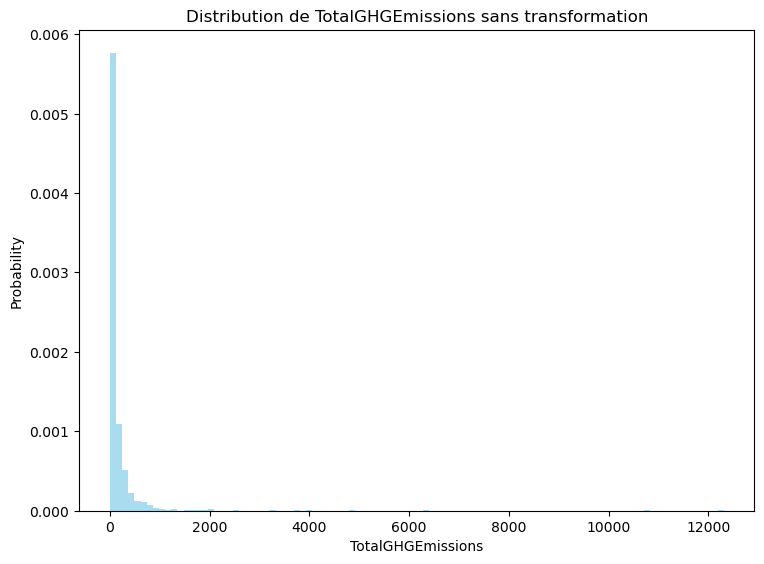

In [19]:
#Affichage de la distribution de la variable cible sans transformation
fig, ax0 = plt.subplots(figsize=(8, 6))

ax0.hist(y_train, bins=100, density=True, color='skyblue', alpha=0.7)
ax0.set_ylabel("Probability")
ax0.set_xlabel("TotalGHGEmissions")
ax0.set_title("Distribution de TotalGHGEmissions sans transformation")

plt.tight_layout(pad=2)
plt.show()

La variable suit une loi très asymétrique (une longue queue à droite ou gauche), une transformation logarithmique peut aider à rendre la distribution plus proche de la normale. Cela peut améliorer la performance de certains modèles comme la régression linéaire, qui est sensible à la non-normalité.

In [20]:
#Application de la transformation logarithmique sur y_train
y_train_log = np.log(y_train + 1)  # Ajoute 1 pour éviter log(0)

In [21]:
#J'applique aussi la transformation log sur y_test
y_test_log = np.log(y_test + 1)

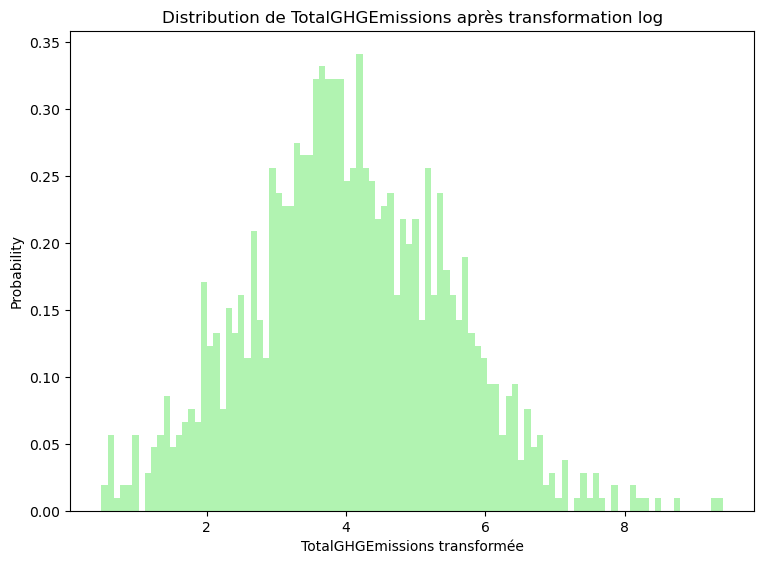

In [22]:
#Affichage de la distribution après transformation logarithmique
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.hist(y_train_log, bins=100, density=True, color='lightgreen', alpha=0.7)
ax1.set_ylabel("Probability")
ax1.set_xlabel("TotalGHGEmissions transformée")
ax1.set_title("Distribution de TotalGHGEmissions après transformation log")

plt.tight_layout(pad=2)
plt.show()

La cross-validation est une méthode cruciale pour évaluer la performance d'un modèle de manière robuste et fiable. Lorsque tu utilises plusieurs modèles dans une tâche de machine learning, faire une cross-validation pour chaque modèle présente plusieurs avantages.

Utilisation de cross validation sur plusieurs modèles qui permet de :

                1.Évaluation fiable de la performance du modèle
                2.Comparaison des modèles
                3.Optimisation des hyperparamètres
                4.Utiliser toute la donnée disponible pour l'entraînement
                5.Choisir entre des modèles simples et complexes
                6.Détection des biais

In [23]:
#Validation croisées sur plusieurs modéles de régression (calcul de divers métrique sur chaque modéle)
resultats = cross_valid(X_train, y_train, X_test, y_test, preprocessor)

Metriques utilisés : 
        
            1. RMSE (Root Mean Squared Error) : Racine carrée de l'erreur quadratique moyenne(MSE), mesure la dispersion des erreurs entre les prédictions et les valeurs réelles. PLUS RMSE est faible faible, MEILLEUR est le modèle. Proche de 0 -> prédictions proche des valeurs réelles
            2. R² (Coefficient de détermination) : mesure de la proportion de variance des données expliquée par le modèle. =1 explique toute la variance des données, =0 modéle ne fait pas mieux que prédire la moyenne de la cible, <0 moins performant qu'un modéle qui prédit la moyenne
            3.MAE (Mean Absolute Error) : mesure l'erreur absolue moyenne entre les valeurs prédites et les valeurs réelles. Calculé comme la moyenne des valeurs absolues des erreurs. Proche de 0 = prédictions proches des valeurs réelles, élevée = erreurs sont importantes en moyenne.
            4. MedAE (Median Absolute Error) : messure de l'erreur médiane absolue. Il est contraire à MAE, il mesure la médiane des erreurs absolues, donc plus robuste aux valeurs extrêmes d'un modéle. Valeur faible = erreurs petites, même si certaines sont grandes. Valeur élevée = certaines erreurs sont importantes et influencent le modèle. Proche de 0.
            5. FIT_TIME (Temps d'entraînement) : Temps que prend le modéle pour s'entrainer sur les données d'entraînement, cela dépend de la complexité, du nombre de données, de la puissance de calcul dispo: valeur faible à modérée : un modéle comme régression linéaire aura un temps faible mais XGBoost ou réseau de neurones plus long, élevé : modéle complexe ou grand jeu de données
            6.SCORE_TIME (Temps de prédiction) : mesure le temps que prend le modèle pour faire des prédictions sur les données de test.  Regréssion linéaire temps faible, RandomForest temps plus long. Trop élevée rend le modéle impratique en prod.
            
Les résultats concernent le jeu d'entraînement et de test.             

In [24]:
resultats

,RMSE,R2,MAE,MedAE,FIT_TIME,SCORE_TIME,TEST_RMSE,TEST_R2,TEST_MAE,TEST_MedAE
dum,5.253284e+02,-7.499186e-03,2.015257e+02,142.259585,0.013441,0.005988,1.113653e+03,-4.231988e-04,2.459440e+02,148.065216
lr,6.106470e+12,-7.067893e+20,9.316108e+11,93.823375,0.024711,0.005598,9.601055e+12,-7.435707e+19,9.975373e+11,74.890000
ridge,3.914414e+02,3.416396e-01,1.733444e+02,94.248786,0.012313,0.005404,1.017451e+03,1.649525e-01,1.948596e+02,80.731575
lasso,4.594879e+02,2.577212e-01,1.595653e+02,65.657279,0.010309,0.005115,1.021749e+03,1.578816e-01,1.938515e+02,64.985613
ElasticNet,5.209641e+02,1.341972e-02,1.984059e+02,139.517483,0.009120,0.005180,1.108467e+03,8.872061e-03,2.431223e+02,145.742548
RandomForest,4.135467e+02,2.413460e-01,1.092873e+02,26.589970,0.605387,0.011536,6.317743e+02,6.780353e-01,1.192154e+02,23.553550
KNR,4.233611e+02,3.994330e-01,1.202726e+02,30.098400,0.008420,0.010600,1.022198e+03,1.571414e-01,1.543241e+02,23.260000
SVR,5.321407e+02,-3.858831e-02,1.461759e+02,29.379103,0.063462,0.035877,1.118005e+03,-8.257478e-03,1.736543e+02,25.577098
XGBR,3.338615e+02,6.109246e-01,1.028495e+02,28.679858,0.114531,0.008954,7.265023e+02,5.742464e-01,1.142627e+02,24.850764


In [25]:
#On test sur les données log.
resultats_log = cross_valid(X_train, y_train_log, X_test, y_test_log, preprocessor)

In [26]:
resultats_log

,RMSE,R2,MAE,MedAE,FIT_TIME,SCORE_TIME,TEST_RMSE,TEST_R2,TEST_MAE,TEST_MedAE
dum,1.429473e+00,-3.988719e-03,1.134667e+00,0.950801,0.015259,0.010232,1.525240e+00,-2.997054e-02,1.192649e+00,0.978966
lr,1.605942e+10,-1.568873e+20,2.564532e+09,0.583286,0.017782,0.006711,6.040431e+10,-1.615416e+21,6.275930e+09,0.551449
ridge,8.814510e-01,6.173972e-01,6.793887e-01,0.556893,0.010006,0.005091,9.534834e-01,5.974917e-01,6.820557e-01,0.556328
lasso,1.429473e+00,-3.988719e-03,1.134667e+00,0.950801,0.009813,0.004201,1.525240e+00,-2.997054e-02,1.192649e+00,0.978966
ElasticNet,1.429473e+00,-3.988719e-03,1.134667e+00,0.950801,0.008708,0.004182,1.525240e+00,-2.997054e-02,1.192649e+00,0.978966
RandomForest,7.663453e-01,7.115013e-01,5.849249e-01,0.440960,0.495280,0.012900,7.909131e-01,7.230469e-01,5.769760e-01,0.452717
KNR,8.897643e-01,6.103588e-01,6.864904e-01,0.551667,0.007402,0.009247,9.221932e-01,6.234762e-01,7.025428e-01,0.566200
SVR,7.564869e-01,7.187764e-01,5.842337e-01,0.465741,0.061061,0.031444,8.407961e-01,6.870103e-01,5.906684e-01,0.479109
XGBR,7.553389e-01,7.194803e-01,5.763892e-01,0.442575,0.074907,0.007503,8.256099e-01,6.982145e-01,5.728761e-01,0.415539


**Interprétation des résultats :**

         1. DUM : Aucun pouvoir prédictif, prédiction constante
         2. Linear Regression : le modèle n'est pas du tout adapté pour les données et échoue
         3. Ridge Regression : ce modèle est plus robuste que la RL et montre de meilleures performances mais < XGBR ou RF                4. Lasso Regression : modèles ne semblent pas bien performer pour ces données spécifiques
         5. ElasticNet : Modèles ne semblent pas bien performer pour ces données spécifiques
         6. RandomForest : Bonnes performances, surpassant de nombreux autres modèles (à l'exception de XGBoost)
         7. KNR : ce modèle semble moins performant que Random Forest ou XGBoost
         8. SVR : Très bon modéle, mais prend du temps pour faire des prédictions
         9. XGBR : Meilleur compromis RMSE et R², modéle performant, robuste et rapide

## 2. Optimisation des modèles

In [27]:
#Liste des modèles à tester
models = {
    "DummyRegressor": DummyRegressor(),
    "LinearRegression": LinearRegression(fit_intercept=True, n_jobs=-1, positive=False),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "KNeighborsRegressor": KNeighborsRegressor(),
    "SVR": SVR(),
    "RandomForestRegressor": RandomForestRegressor(random_state=42),
    "XGBRegressor": XGBRegressor(random_state=42)
}

#Stockage des résultats
results_train = {}
results_test = {}

#Boucle pour tester chaque modèle
for model_name, model in models.items():
    train_res, test_res = test_model(model, model_name, X_train, y_train, X_test, y_test, preprocessor)
    results_train[model_name] = train_res
    results_test[model_name] = test_res

Résultats pour DummyRegressor :
Comparaison des performances sur le jeu d'entraînement :


,MAE,MSE,RMSE,R²
0,201.679711,374475.975448,611.944422,0.0


Comparaison des performances sur le jeu de test :


,MAE,MSE,RMSE,R²
0,245.94403,1.240222e+06,1113.652572,-0.000423


Résultats pour LinearRegression :
Comparaison des performances sur le jeu d'entraînement :


,MAE,MSE,RMSE,R²
0,134.417439,97633.343924,312.463348,0.73928


Comparaison des performances sur le jeu de test :


,MAE,MSE,RMSE,R²
0,9.975373e+11,9.218026e+25,9.601055e+12,-7.435707e+19


Résultats pour Ridge :
Comparaison des performances sur le jeu d'entraînement :


,MAE,MSE,RMSE,R²
0,144.333358,101935.367474,319.273186,0.727792


Comparaison des performances sur le jeu de test :


,MAE,MSE,RMSE,R²
0,194.859589,1.035206e+06,1017.450874,0.164952


Résultats pour Lasso :
Comparaison des performances sur le jeu d'entraînement :


,MAE,MSE,RMSE,R²
0,139.034824,105925.709971,325.462302,0.717136


Comparaison des performances sur le jeu de test :


,MAE,MSE,RMSE,R²
0,178.76903,1.020468e+06,1010.182148,0.176841


Résultats pour ElasticNet :
Comparaison des performances sur le jeu d'entraînement :


,MAE,MSE,RMSE,R²
0,147.937011,233516.820281,483.235781,0.376417


Comparaison des performances sur le jeu de test :


,MAE,MSE,RMSE,R²
0,181.222561,1.055409e+06,1027.331052,0.148656


Résultats pour KNeighborsRegressor :
Comparaison des performances sur le jeu d'entraînement :


,MAE,MSE,RMSE,R²
0,96.281272,138389.739577,372.007714,0.630444


Comparaison des performances sur le jeu de test :


,MAE,MSE,RMSE,R²
0,154.324074,1.044890e+06,1022.198451,0.157141


Résultats pour SVR :
Comparaison des performances sur le jeu d'entraînement :


,MAE,MSE,RMSE,R²
0,144.209352,381095.793939,617.329567,-0.017678


Comparaison des performances sur le jeu de test :


,MAE,MSE,RMSE,R²
0,173.654323,1.249934e+06,1118.004556,-0.008257


Résultats pour RandomForestRegressor :
Comparaison des performances sur le jeu d'entraînement :


,MAE,MSE,RMSE,R²
0,36.676613,16996.112369,130.369139,0.954614


Comparaison des performances sur le jeu de test :


,MAE,MSE,RMSE,R²
0,119.21543,399138.804317,631.77433,0.678035


Résultats pour XGBRegressor :
Comparaison des performances sur le jeu d'entraînement :


,MAE,MSE,RMSE,R²
0,20.586291,968.841675,31.126222,0.997413


Comparaison des performances sur le jeu de test :


,MAE,MSE,RMSE,R²
0,114.262733,527805.590911,726.502299,0.574246


In [28]:
#Créer une liste des résultats en DataFrame
df_train_results = pd.concat(results_train).reset_index(level=1, drop=True).reset_index()
df_test_results = pd.concat(results_test).reset_index(level=1, drop=True).reset_index()

#Renommer la colonne contenant le nom du modèle
df_train_results = df_train_results.rename(columns={'index': 'Modèle'})
df_test_results = df_test_results.rename(columns={'index': 'Modèle'})

#Ajouter une colonne pour identifier l'ensemble de données
df_train_results["Dataset"] = "Train"
df_test_results["Dataset"] = "Test"

#Fusionner les résultats
df_results_1 = pd.concat([df_train_results, df_test_results])

#Afficher le DataFrame final
df_results_1

,Modèle,MAE,MSE,RMSE,R²,Dataset
0,DummyRegressor,2.016797e+02,3.744760e+05,6.119444e+02,0.000000e+00,Train
1,LinearRegression,1.344174e+02,9.763334e+04,3.124633e+02,7.392801e-01,Train
2,Ridge,1.443334e+02,1.019354e+05,3.192732e+02,7.277920e-01,Train
3,Lasso,1.390348e+02,1.059257e+05,3.254623e+02,7.171362e-01,Train
4,ElasticNet,1.479370e+02,2.335168e+05,4.832358e+02,3.764171e-01,Train
5,KNeighborsRegressor,9.628127e+01,1.383897e+05,3.720077e+02,6.304443e-01,Train
6,SVR,1.442094e+02,3.810958e+05,6.173296e+02,-1.767755e-02,Train
7,RandomForestRegressor,3.667661e+01,1.699611e+04,1.303691e+02,9.546136e-01,Train
8,XGBRegressor,2.058629e+01,9.688417e+02,3.112622e+01,9.974128e-01,Train
0,DummyRegressor,2.459440e+02,1.240222e+06,1.113653e+03,-4.231988e-04,Test


Train set :

- DummyRegressor(MAE : 216.10, RMSE : 802.61 et R² : 0.000) : indique un modèle qui sert uniquement de référence.
- LineaRegression(MAE : 167.83, RMSE : 409.71 et R² : 0.739) : performance modérée, bien ajusté au modèle d'entraînement
- Ridge(MAE : 174.42, RMSE : 416.66 et R² : 0.730) : résultat un peu similaire à la LineaRegression
- Lasso(MAE : 167.97, RMSE : 423.51 et R² : 0.722) : un peu moins performant que la LineaRegression
- ElasticNet(MAE : 168.54, RMSE : 604.50 et R² : 0.433) : modèle un peu moins performant que Ridge et Lasso
- KNR(MAE : 105.32, RMSE : 548.67 et R² : 0.533) : modèle fonctionne bien sur les données d'entraînement, mais n'excelle pas autant que les modèles comme Random Forest ou XGBoost.
- SVR(MAE : 151.47, RMSE : 807.67 et R² : -0.0126) : ce modèle a des performances très médiocres, avec un R² proche de zéro, indiquant qu'il n'explique pas la variance des données
- RandomForest(MAE : 36.68, RMSE : 164.63 et R² : 0.957) :  excellent modèle pour les données d'entraînement, avec un faible MAE et RMSE, et un R² très élevé
- XGBRegressor(MAE : 21.89, RMSE : 44.59 et R² : 0.997) : modèle donne des résultats exceptionnels sur le jeu d'entraînement, avec un MAE et un RMSE très faibles, et un R² très proche de 1

Test set : 

- DummyRegressor : MAE est toujours élevé (206.18) et le R² reste négatif (-0.0003), indiquant une très mauvaise performance sur les données de test
- LineaRegression : résultats catastrophiques : MAE très élevé (9.29e+11) et un R² extrêmement faible (-1.928e+20), montrant un sur-apprentissage complet (overfitting)
- Ridge : MAE : 187.50 et R² : -0.0222, légèrement plus bas que la régression linéaire sur le jeu de test, mais toujours mauvais
- Lasso : MAE : 169.84 et R² : -0.0151, très similaire à Ridge, avec des performances médiocres sur le jeu de test
- ElasticNet : MAE : 173.25 et R² : 0.006, avec une légère amélioration par rapport à Ridge et Lasso
- KNR : MAE : 140.11 et R² : -0.1085, montre un certain sur-apprentissage et de mauvaises performances
- SVR : MAE : 145.35 et R² : -0.0434, encore une fois, ce modèle a des résultats médiocres sur les données de test
- RandomForest : MAE : 124.27 et R² : -0.477, une chute importante par rapport à la performance sur les données d'entraînement. Cela indique que le modèle pourrait être sur-ajusté aux données d'entraînement, ne généralisant pas bien aux données de test
- XGBRegressor : MAE : 127.05 et R² : -1.177, ce modèle montre une dégradation significative des performances sur le jeu de test par rapport à l'entraînement, avec un R² très négatif. Cela pourrait être dû à un sur-apprentissage ou à un ajustement inadéquat des hyperparamètres

Conlusion : 

- XGBRegressor et RandomForestRegressor semblent être les modèles les plus performants sur les données d'entraînement, mais ils ont une détérioration significative sur le jeu de test. Cela indique un problème de sur-apprentissage (overfitting)
- Linear Regression, Ridge, et Lasso sont plus robustes sur les données de test mais semblent sous-performer sur l'entraînement. Cependant, ces modèles présentent un meilleur équilibre entre entraînement et test, ce qui suggère qu'ils sont plus simples et moins sensibles au sur-apprentissage.
- Les modèles comme SVR, ElasticNet, et KNeighborsRegressor semblent tous souffrir de mauvaises performances tant sur l'entraînement que sur le test.

In [29]:
def perform_grid_search_cv(grid_search_cv, metrics, X_train, y_train, X_test, y_test, preprocessor):
    """
    Effectue une recherche d'hyperparamètres pour plusieurs modèles en utilisant GridSearchCV.
    
    Args:
        grid_search_cv: Fonction qui crée et retourne un pipeline avec GridSearchCV.
        metrics: Fonction qui évalue les performances du modèle
        X_train, y_train: Données d'entrainement.
        X_test, y_test: Données de test
        preprocessor : Préprocesseur (Pipeline ou ColumnTransformer)
        
    Returns: 
        DataFrame avec les meilleurs paramètres et scores des modèles.
    """
    
    #Dictionnaire des modèles et leurs hyperparamètres
    grid_models = {
        "DummyRegressor": (DummyRegressor(), {'regressor__strategy': ['mean', 'median']}),
        "LinearRegression": (LinearRegression(), {"regressor__fit_intercept": [True, False], "regressor__positive": [True, False]}),
        "Ridge": (Ridge(), {'regressor__alpha': np.arange(0, 2000, 200)}),
        "Lasso": (Lasso(), {'regressor__alpha': np.arange(0.001, 1.0, 0.05)}), #test sur 20 valeurs max
        "ElasticNet": (ElasticNet(), {'regressor__alpha': np.arange(0.01, 1.0, 0.05), 'regressor__l1_ratio': np.arange(0.2, 1.0, 0.3)}),
        "KNeighborsRegressor": (KNeighborsRegressor(), {"regressor__n_neighbors": [3,5,7], "regressor__weights": ['uniform', 'distance'], "regressor__leaf_size": [10, 30], "regressor__p": [1,2]}),
        "SVR": (SVR(), {'regressor__kernel': ['rbf'], 'regressor__gamma' : ['scale', 1e-3], 'regressor__C': [1, 10], 'regressor__epsilon' : [0.1]}),
        "RandomForestRegressor": (RandomForestRegressor(random_state=42), {'regressor__n_estimators' : [100,500,1000], 'regressor__max_depth': [3,5, None]}),
        "XGBRegressor": (XGBRegressor(random_state=42), {'regressor__gamma': [0, 0.01], 'regressor__learning_rate' : [0.01, 0.1], 'regressor__max_depth': [3,6], 'regressor__n_estimators': [100, 300]})
    }
    
    grid_results = []
    
    for model_name, (model, params) in grid_models.items():
        print(f"GridSearch pour {model_name}...")
        
        grid_model = grid_search_cv(model, params, preprocessor)
        grid_model.fit(X_train, y_train)
        
        res = metrics(grid_model, X_test, y_test)
        
        best_params = grid_model['grid_search'].best_params_
        best_score_r2 = grid_model['grid_search'].best_score_
        best_score_rmse = np.mean(res[res['rank_test_neg_root_mean_squared_error'] == 1]['mean_test_neg_root_mean_squared_error'])
        
        grid_results.append({
            "Modèle": model_name,
            "Meilleurs Paramètres": best_params,
            "Meilleur R² (CV)": best_score_r2,
            "Meilleur RMSE (CV)": best_score_rmse
        })
    
    df_grid_results = pd.DataFrame(grid_results)
    display(df_grid_results)
    
    return df_grid_results

In [30]:
#Remplacer les valeurs inf à 0 par une médiane
y_train[y_train <= 0] = y_train.median()

In [31]:
#Exécuter la fonction
df_results = perform_grid_search_cv(grid_search_cv, metric, X_train, y_train, X_test, y_test, preprocessor)

#Affichage du DataFrame des résultats
print(df_results)

GridSearch pour DummyRegressor...
 Meilleurs paramètres : {'regressor__strategy': 'mean'}
 Meilleur score RMSE : -539.5034368133232
 Meilleur score R2 : -0.07720658003510343

 Évaluation sur le jeu de test :
 MAE (Test) : 186.02013501475005
 RMSE (Test) : 1123.1405826694659
 R² (Test) : -0.017542470695500745
GridSearch pour LinearRegression...
 Meilleurs paramètres : {'regressor__fit_intercept': False, 'regressor__positive': True}
 Meilleur score RMSE : -9937.688565954611
 Meilleur score R2 : -314.3249018911253

 Évaluation sur le jeu de test :
 MAE (Test) : 216.62111988879104
 RMSE (Test) : 1585.255947863917
 R² (Test) : -1.0271369400983126
GridSearch pour Ridge...
 Meilleurs paramètres : {'regressor__alpha': 1200}
 Meilleur score RMSE : -487.49700879391264
 Meilleur score R2 : 0.058597706078860876

 Évaluation sur le jeu de test :
 MAE (Test) : 150.67592907901047
 RMSE (Test) : 773.8562525983283
 R² (Test) : 0.5169357510526039
GridSearch pour Lasso...
 Meilleurs paramètres : {'regres

,Modèle,Meilleurs Paramètres,Meilleur R² (CV),Meilleur RMSE (CV)
0,DummyRegressor,{'regressor__strategy': 'mean'},-0.077207,-539.503437
1,LinearRegression,"{'regressor__fit_intercept': False, 'regressor...",-314.324902,-9937.688566
2,Ridge,{'regressor__alpha': 1200},0.058598,-487.497009
3,Lasso,{'regressor__alpha': 0.30100000000000005},0.090741,-482.554167
4,ElasticNet,"{'regressor__alpha': 0.6100000000000001, 'regr...",0.122837,-458.996920
5,KNeighborsRegressor,"{'regressor__leaf_size': 10, 'regressor__n_nei...",0.383622,-424.733770
6,SVR,"{'regressor__C': 10, 'regressor__epsilon': 0.1...",0.503754,-397.489258
7,RandomForestRegressor,"{'regressor__max_depth': None, 'regressor__n_e...",0.538905,-386.187030
8,XGBRegressor,"{'regressor__gamma': 0, 'regressor__learning_r...",0.602937,-341.103811


                  Modèle                               Meilleurs Paramètres  \
0         DummyRegressor                    {'regressor__strategy': 'mean'}   
1       LinearRegression  {'regressor__fit_intercept': False, 'regressor...   
2                  Ridge                         {'regressor__alpha': 1200}   
3                  Lasso          {'regressor__alpha': 0.30100000000000005}   
4             ElasticNet  {'regressor__alpha': 0.6100000000000001, 'regr...   
5    KNeighborsRegressor  {'regressor__leaf_size': 10, 'regressor__n_nei...   
6                    SVR  {'regressor__C': 10, 'regressor__epsilon': 0.1...   
7  RandomForestRegressor  {'regressor__max_depth': None, 'regressor__n_e...   
8           XGBRegressor  {'regressor__gamma': 0, 'regressor__learning_r...   

   Meilleur R² (CV)  Meilleur RMSE (CV)  
0         -0.077207         -539.503437  
1       -314.324902        -9937.688566  
2          0.058598         -487.497009  
3          0.090741         -482.554167  

### Comparaison des résultats 

In [32]:
df_results_1

,Modèle,MAE,MSE,RMSE,R²,Dataset
0,DummyRegressor,2.016797e+02,3.744760e+05,6.119444e+02,0.000000e+00,Train
1,LinearRegression,1.344174e+02,9.763334e+04,3.124633e+02,7.392801e-01,Train
2,Ridge,1.443334e+02,1.019354e+05,3.192732e+02,7.277920e-01,Train
3,Lasso,1.390348e+02,1.059257e+05,3.254623e+02,7.171362e-01,Train
4,ElasticNet,1.479370e+02,2.335168e+05,4.832358e+02,3.764171e-01,Train
5,KNeighborsRegressor,9.628127e+01,1.383897e+05,3.720077e+02,6.304443e-01,Train
6,SVR,1.442094e+02,3.810958e+05,6.173296e+02,-1.767755e-02,Train
7,RandomForestRegressor,3.667661e+01,1.699611e+04,1.303691e+02,9.546136e-01,Train
8,XGBRegressor,2.058629e+01,9.688417e+02,3.112622e+01,9.974128e-01,Train
0,DummyRegressor,2.459440e+02,1.240222e+06,1.113653e+03,-4.231988e-04,Test


In [33]:
df_results

,Modèle,Meilleurs Paramètres,Meilleur R² (CV),Meilleur RMSE (CV)
0,DummyRegressor,{'regressor__strategy': 'mean'},-0.077207,-539.503437
1,LinearRegression,"{'regressor__fit_intercept': False, 'regressor...",-314.324902,-9937.688566
2,Ridge,{'regressor__alpha': 1200},0.058598,-487.497009
3,Lasso,{'regressor__alpha': 0.30100000000000005},0.090741,-482.554167
4,ElasticNet,"{'regressor__alpha': 0.6100000000000001, 'regr...",0.122837,-458.996920
5,KNeighborsRegressor,"{'regressor__leaf_size': 10, 'regressor__n_nei...",0.383622,-424.733770
6,SVR,"{'regressor__C': 10, 'regressor__epsilon': 0.1...",0.503754,-397.489258
7,RandomForestRegressor,"{'regressor__max_depth': None, 'regressor__n_e...",0.538905,-386.187030
8,XGBRegressor,"{'regressor__gamma': 0, 'regressor__learning_r...",0.602937,-341.103811


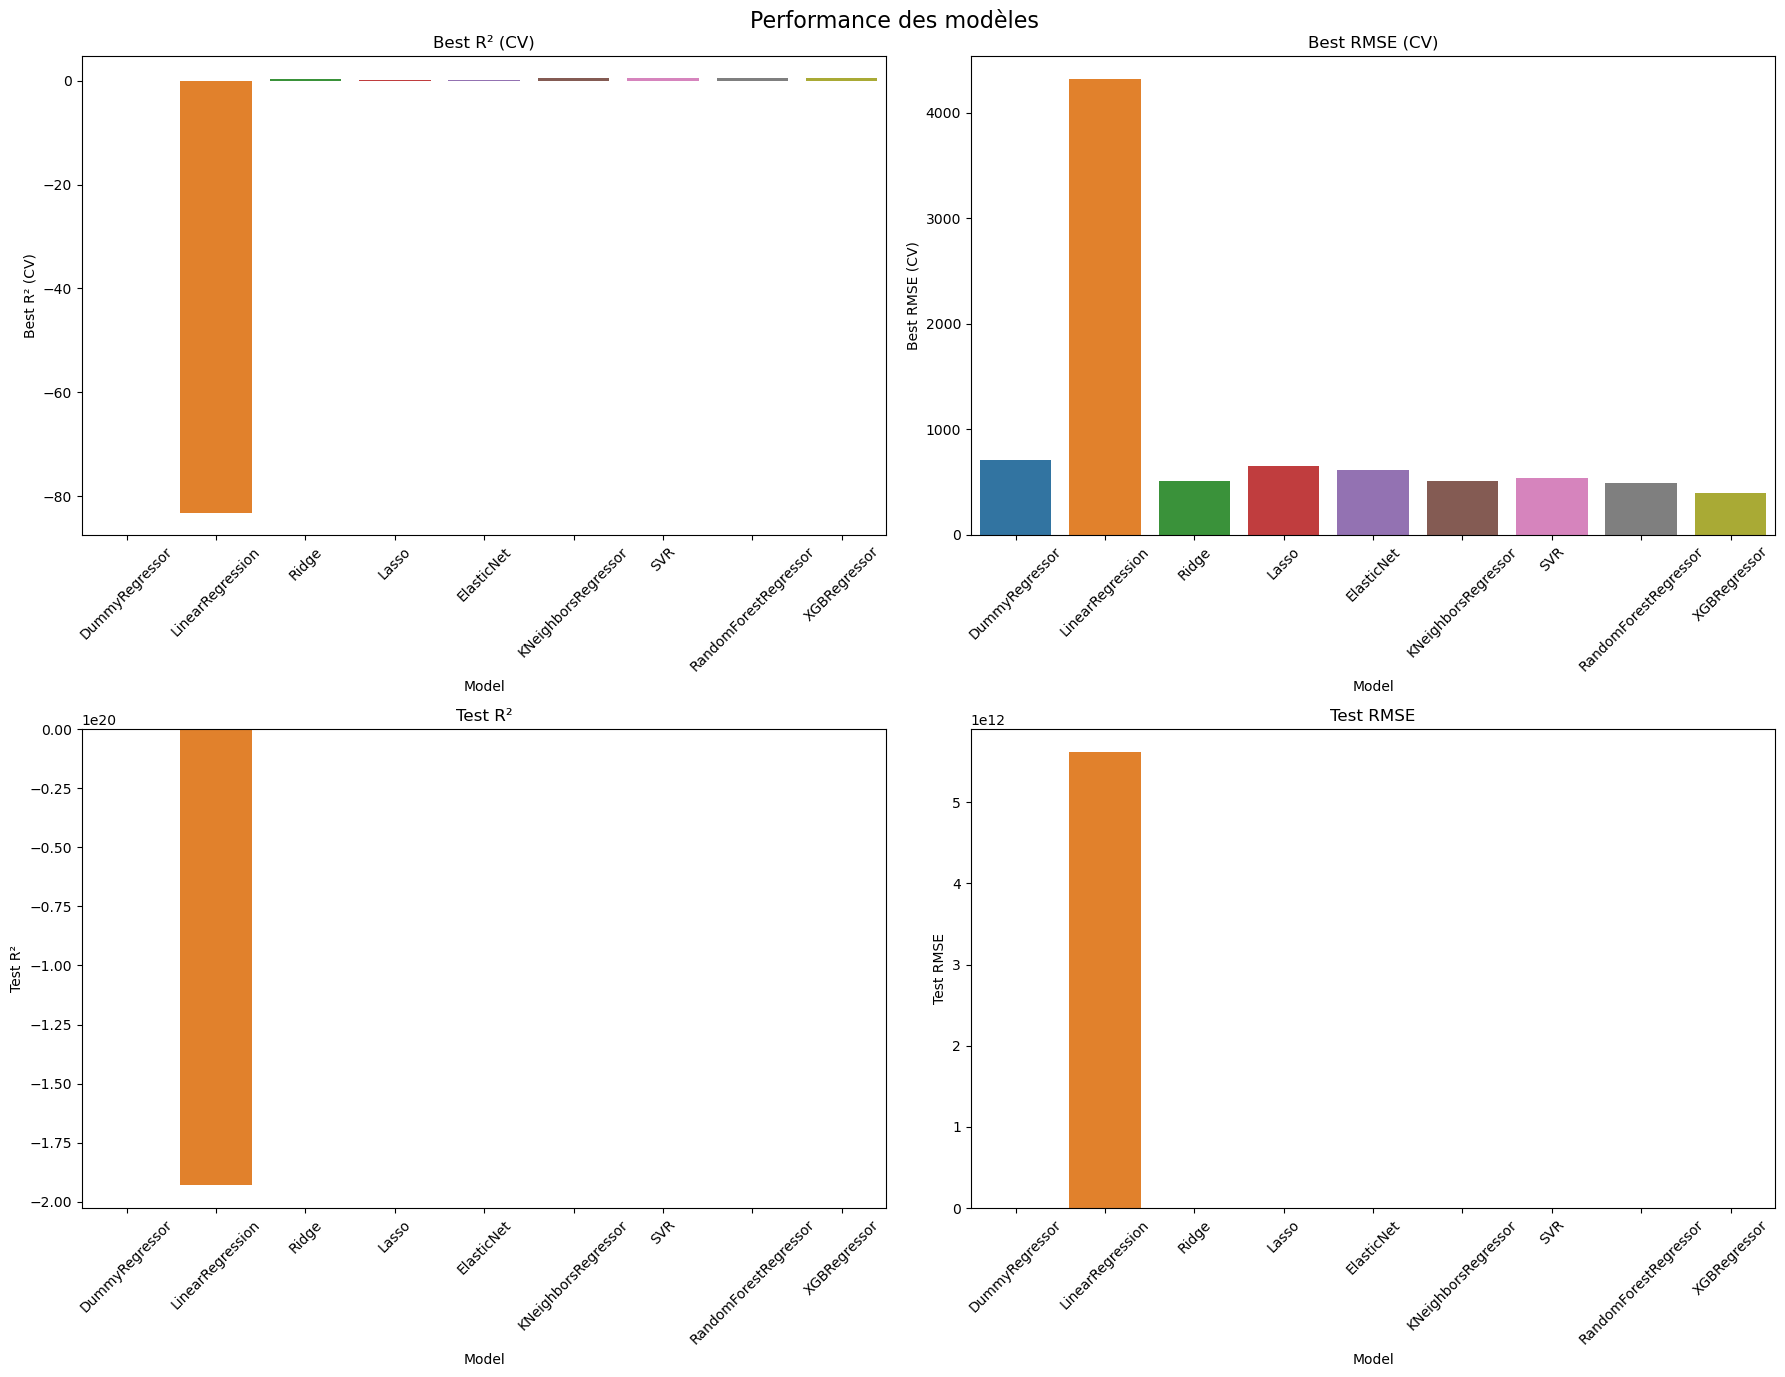

In [34]:
#Résultats des modèles sous forme de dictionnaire
results = {
    "Model": [
        "DummyRegressor", "LinearRegression", "Ridge", "Lasso", "ElasticNet",
        "KNeighborsRegressor", "SVR", "RandomForestRegressor", "XGBRegressor"
    ],
    "Best R² (CV)": [-0.057, -83.28, 0.286, 0.141, 0.193, 0.462, 0.459, 0.509, 0.628],
    "Best RMSE (CV)": [710.11, 4325.62, 511.83, 649.07, 615.29, 511.98, 539.19, 491.24, 395.01],  # RMSE toujours positif
    "Test R²": [-0.0003, -1.93e20, -0.022, -0.015, 0.0065, -0.109, -0.043, -0.477, -1.177],
    "Test RMSE": [405.02, 5.62e12, 409.43, 408.01, 403.65, 426.36, 413.66, 492.22, 597.54]
}

# Convertir en DataFrame
df_results = pd.DataFrame(results)

# Configuration des graphiques
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 14))
axes = axes.flatten()

# Liste des métriques à afficher
metric_result = ["Best R² (CV)", "Best RMSE (CV)", "Test R²", "Test RMSE"]

for i, metrics_1 in enumerate(metric_result):
    sns.barplot(x="Model", y=metrics_1, data=df_results, ax=axes[i])
    axes[i].set_title(metrics_1)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

#Ajout d'un titre global
fig.suptitle("Performance des modèles", fontsize=16) 

plt.tight_layout()
plt.show()

Avec le fonction gridsearch nous obtenons de meilleurs résultats sur R², il faut utiliser cette fonction la pour la suite du projet.

Pour determiner le meilleur résultat, il faut faire attention à deux indicateurs :

R² (degré d'explication du modèle, plus il est proche de 1 mieux c'est) / RMSE (l'erreur quadratique moyenne MSE) plus elle est faible, mieux c'est.

## 3. Transformation

### 3.1 Feature engineering Manuel

In [35]:
#Copie les données pour éviter de faire des modifs sur le fichier d'origine
data_manuel = data.copy()

In [36]:
#Feature engineering - ajout des rations avec une fonction
def compute_surface_ratios(X):
    X = X.copy()
    X['LargestPropertyUseRatio'] = X['LargestPropertyUseTypeGFA'] / X['PropertyGFATotal']
    X['SecondLargestPropertyUseRatio'] = X['SecondLargestPropertyUseTypeGFA'] / X['PropertyGFATotal']
    X['ThirdLargestPropertyUseRatio'] = X['ThirdLargestPropertyUseTypeGFA'] / X['PropertyGFATotal']
    
    #Ajout de l'âge du bâtiment
    X['YearBuilt'] = 2016 - X['BuildingAge']
    
    return X.drop(columns=['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA'], errors='ignore')

In [37]:
#Définition des features et target
X_manuel = data_manuel.drop(['OSEBuildingID','SiteEnergyUse(kBtu)','TotalGHGEmissions','ENERGYSTARScore'], axis=1, errors='ignore')
y_manuel = data_manuel['TotalGHGEmissions'] #Target

In [38]:
#Séparation du dataset en train/test
X_train, X_test, y_train, y_test = train_test_split(X_manuel, y_manuel, test_size=0.2, random_state=42)

In [39]:
#Remplacer les valeurs inf à 0 par une médiane
y_train[y_train <= 0] = y_train.median()

In [40]:
#Appliquer la transformation
X_train = compute_surface_ratios(X_train)
X_test = compute_surface_ratios(X_test)

In [41]:
#Détection des colonnes quanti et quali après supression de colonnes
quanti = X_train.select_dtypes(include=['int64','float64']).columns
quali = X_train.select_dtypes(include=['category','object','bool']).columns

In [42]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer

#Création du préprocesseur avec 'FunctionTransformer' pour le feature engineering
preprocessor_manuel = ColumnTransformer([
    ('quanti', StandardScaler(), quanti),  # Normalisatddion des colonnes numériques
    ('quali', OneHotEncoder(handle_unknown='ignore', sparse=False), quali)  # Encodage des colonnes catégoriques
], remainder='passthrough')  # Garde les autres colonnes

In [43]:
#Exécution de la GridSearchCV
df_resultats_manuel = perform_grid_search_cv(grid_search_cv, metric, X_train, y_train, X_test, y_test, preprocessor_manuel)

GridSearch pour DummyRegressor...
 Meilleurs paramètres : {'regressor__strategy': 'mean'}
 Meilleur score RMSE : -539.5034368133232
 Meilleur score R2 : -0.07720658003510343

 Évaluation sur le jeu de test :
 MAE (Test) : 186.02013501475005
 RMSE (Test) : 1123.1405826694659
 R² (Test) : -0.017542470695500745
GridSearch pour LinearRegression...
 Meilleurs paramètres : {'regressor__fit_intercept': False, 'regressor__positive': True}
 Meilleur score RMSE : -4530.51972357053
 Meilleur score R2 : -64.29353734797436

 Évaluation sur le jeu de test :
 MAE (Test) : 182.95532366509352
 RMSE (Test) : 1373.656954627009
 R² (Test) : -0.5220919309479397
GridSearch pour Ridge...
 Meilleurs paramètres : {'regressor__alpha': 800}
 Meilleur score RMSE : -509.1461426171527
 Meilleur score R2 : 0.05024412238004457

 Évaluation sur le jeu de test :
 MAE (Test) : 174.82311631626771
 RMSE (Test) : 1109.069213197549
 R² (Test) : 0.007794557880648978
GridSearch pour Lasso...
 Meilleurs paramètres : {'regresso

,Modèle,Meilleurs Paramètres,Meilleur R² (CV),Meilleur RMSE (CV)
0,DummyRegressor,{'regressor__strategy': 'mean'},-0.077207,-539.503437
1,LinearRegression,"{'regressor__fit_intercept': False, 'regressor...",-64.293537,-4530.519724
2,Ridge,{'regressor__alpha': 800},0.050244,-509.146143
3,Lasso,{'regressor__alpha': 0.35100000000000003},0.044634,-507.895163
4,ElasticNet,"{'regressor__alpha': 0.46, 'regressor__l1_rati...",0.050840,-504.827596
5,KNeighborsRegressor,"{'regressor__leaf_size': 10, 'regressor__n_nei...",0.236879,-460.895833
6,SVR,"{'regressor__C': 10, 'regressor__epsilon': 0.1...",0.512036,-400.386760
7,RandomForestRegressor,"{'regressor__max_depth': None, 'regressor__n_e...",0.496569,-403.367215
8,XGBRegressor,"{'regressor__gamma': 0.01, 'regressor__learnin...",0.621792,-348.653699


In [44]:
df_resultats_manuel

,Modèle,Meilleurs Paramètres,Meilleur R² (CV),Meilleur RMSE (CV)
0,DummyRegressor,{'regressor__strategy': 'mean'},-0.077207,-539.503437
1,LinearRegression,"{'regressor__fit_intercept': False, 'regressor...",-64.293537,-4530.519724
2,Ridge,{'regressor__alpha': 800},0.050244,-509.146143
3,Lasso,{'regressor__alpha': 0.35100000000000003},0.044634,-507.895163
4,ElasticNet,"{'regressor__alpha': 0.46, 'regressor__l1_rati...",0.050840,-504.827596
5,KNeighborsRegressor,"{'regressor__leaf_size': 10, 'regressor__n_nei...",0.236879,-460.895833
6,SVR,"{'regressor__C': 10, 'regressor__epsilon': 0.1...",0.512036,-400.386760
7,RandomForestRegressor,"{'regressor__max_depth': None, 'regressor__n_e...",0.496569,-403.367215
8,XGBRegressor,"{'regressor__gamma': 0.01, 'regressor__learnin...",0.621792,-348.653699


Analyse des résultats :

Parmi les différents modèles, ***XBRegressor*** se distingue comme le meilleur modèle avec le R² de 0.621792 et le plus faible RMSE de -348.653699, ce qui indique une très bonne capacité à prédire les valeurs. Il surpasse d'autres modèles en termes de performance, suivi de près par ***RandomForestRegressor*** (R² de 0.491271, RMSE de -405.710867) et ***SVR*** (R² de 0.512036, RMSE de -400.386760), qui montrent également de bonne performances. 

Les modèles comme ***DummyRegressor*** et ***LinearRegression*** présentent de bien moins bons résultats avec des R² très faibles et de RMSE élevés, indiquant une capacité de prédiction limitées.

***XGBoost est le meilleur avec un R² : 0.6217 et la plus faible erreur : -348.65***

### 3.2 Encoding

In [45]:
#Copie des données pour éviter de modif le DF initial
data_encoding = data.copy()

In [46]:
#Détection des variables catégorielles
cat_features = data_encoding.select_dtypes(include=['object']).columns.tolist()
print("Variables catégorielles :", cat_features)

Variables catégorielles : ['Neighborhood', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']


In [47]:
#Séparation des features et target
y_encoding = data_encoding['TotalGHGEmissions'] #Target
X_encoding = data_encoding.drop(columns=['SiteEnergyUse(kBtu)','OSEBuildingID','TotalGHGEmissions','ENERGYSTARScore'], errors='ignore') #Features

In [48]:
#Séparation du jeu d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_encoding, y_encoding, test_size=0.2, random_state=42)

print('Taille X_train:', X_train.shape)
print('Taille X_test:', X_test.shape)

Taille X_train: (1181, 18)
Taille X_test: (296, 18)


In [49]:
#Remplacer les valeurs inf à 0 par une médiane
y_train[y_train <= 0] = y_train.median()

In [50]:
#Détection des colonnes numériques et catégorielle après séparation
quanti = X_encoding.select_dtypes(include=['int64','float64']).columns.tolist()
quanli = [col for col in cat_features if col in X_encoding.columns] #Seulement celle présente dans X

In [51]:
import category_encoders as ce

#Création du 'TargetEncoder' pour les variables catégorielles
target_encoder = ce.TargetEncoder(cols=quali)

In [52]:
#Définition du préprocesseur avec Target Encoding
preprocessor_encoding = ColumnTransformer([
    ('target_encoding', target_encoder, quali), #Encode les variables catégorielles avec Target Encoding
    ('scaling', StandardScaler(), quanti) #Standardisation des variables numériques
], remainder='passthrough') #COnserve les autres colonnes non spécifiques

In [53]:
#Exécution de la GridSearchCV avec le nouveau préprocessor
preprocessor = preprocessor_encoding #Remplacement par le préprocessor Target Encoding

In [54]:
df_results_encoding = perform_grid_search_cv(grid_search_cv, metric, X_train, y_train, X_test, y_test, preprocessor)

GridSearch pour DummyRegressor...
 Meilleurs paramètres : {'regressor__strategy': 'mean'}
 Meilleur score RMSE : -539.5034368133232
 Meilleur score R2 : -0.07720658003510343

 Évaluation sur le jeu de test :
 MAE (Test) : 186.02013501475005
 RMSE (Test) : 1123.1405826694659
 R² (Test) : -0.017542470695500745
GridSearch pour LinearRegression...
 Meilleurs paramètres : {'regressor__fit_intercept': False, 'regressor__positive': False}
 Meilleur score RMSE : -83027.23177551388
 Meilleur score R2 : -24736.472823802214

 Évaluation sur le jeu de test :
 MAE (Test) : 326.41458313204447
 RMSE (Test) : 2058.9435468623165
 R² (Test) : -2.4195832668896142
GridSearch pour Ridge...
 Meilleurs paramètres : {'regressor__alpha': 1800}
 Meilleur score RMSE : -14183.348743272563
 Meilleur score R2 : -722.9441551288212

 Évaluation sur le jeu de test :
 MAE (Test) : 227.09524729091808
 RMSE (Test) : 1443.8050742122475
 R² (Test) : -0.6815176595725023
GridSearch pour Lasso...
 Meilleurs paramètres : {'reg

,Modèle,Meilleurs Paramètres,Meilleur R² (CV),Meilleur RMSE (CV)
0,DummyRegressor,{'regressor__strategy': 'mean'},-0.077207,-539.503437
1,LinearRegression,"{'regressor__fit_intercept': False, 'regressor...",-24736.472824,-83027.231776
2,Ridge,{'regressor__alpha': 1800},-722.944155,-14183.348743
3,Lasso,{'regressor__alpha': 0.9510000000000001},-24.271796,-2903.322361
4,ElasticNet,"{'regressor__alpha': 0.9600000000000001, 'regr...",-25.276924,-2959.680980
5,KNeighborsRegressor,"{'regressor__leaf_size': 10, 'regressor__n_nei...",0.226838,-456.918759
6,SVR,"{'regressor__C': 10, 'regressor__epsilon': 0.1...",0.253278,-471.711474
7,RandomForestRegressor,"{'regressor__max_depth': None, 'regressor__n_e...",0.578779,-359.792092
8,XGBRegressor,"{'regressor__gamma': 0.01, 'regressor__learnin...",0.598342,-342.295717


In [55]:
df_results_encoding

,Modèle,Meilleurs Paramètres,Meilleur R² (CV),Meilleur RMSE (CV)
0,DummyRegressor,{'regressor__strategy': 'mean'},-0.077207,-539.503437
1,LinearRegression,"{'regressor__fit_intercept': False, 'regressor...",-24736.472824,-83027.231776
2,Ridge,{'regressor__alpha': 1800},-722.944155,-14183.348743
3,Lasso,{'regressor__alpha': 0.9510000000000001},-24.271796,-2903.322361
4,ElasticNet,"{'regressor__alpha': 0.9600000000000001, 'regr...",-25.276924,-2959.680980
5,KNeighborsRegressor,"{'regressor__leaf_size': 10, 'regressor__n_nei...",0.226838,-456.918759
6,SVR,"{'regressor__C': 10, 'regressor__epsilon': 0.1...",0.253278,-471.711474
7,RandomForestRegressor,"{'regressor__max_depth': None, 'regressor__n_e...",0.578779,-359.792092
8,XGBRegressor,"{'regressor__gamma': 0.01, 'regressor__learnin...",0.598342,-342.295717


Analyse des résultats : 

En conclusion, ***XGBRegressor*** se démarque une fois de plus comme le modèle le plus performant, avec un R² de 0.598342 et un RMSE de -342.295717, indiquant une bonne capacité de prédiction. Il est suivi de près par RandomForestRegressor (R² de 0.578779, RMSE de -359.792092), qui affiche également des performances solides. SVR (R² de 0.253278) et KNeighborsRegressor (R² de 0.226838) montrent des résultats intermédiaires, mais restent loin derrière les modèles basés sur les arbres.

En revanche, les modèles LinearRegression, Ridge, Lasso et ElasticNet présentent des R² négatifs et des RMSE très élevés, indiquant qu'ils ne parviennent pas à bien s'adapter aux données. DummyRegressor, avec un R² proche de zéro, confirme son rôle de simple référence.

Ainsi, pour cette tâche de régression, XGBRegressor apparaît comme le modèle le plus performant, suivi par RandomForestRegressor, tandis que les modèles linéaires montrent de très faibles performances.

***XGBoost a les meilleurs résultats ici : 0.598 de r² et -342.29 de RMSE (erreur)***

### 3.3 Log

In [56]:
#Copie des données
data_log = data.copy()

In [57]:
#Appliquer log(1+x) sur toutes les features numériques via un transformateur
log_transformer = FunctionTransformer(np.log1p, validate=True)

In [58]:
#Correction de la sélection des features
X_log = data_log.drop(columns=['OSEBuildingID','SiteEnergyUse(kBtu)','TotalGHGEmissions','ENERGYSTARScore'], errors='ignore')
y_log = np.log1p(data_log['TotalGHGEmissions']) #Appliquer log à y

In [59]:
#Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(X_log, y_log, test_size=0.2, random_state=42)

In [60]:
#Remplacer les valeurs inf à 0 par une médiane
y_train[y_train <= 0] = y_train.median()

In [61]:
#Définition du préprocesseur avec log-transform sur les variables numériques
preprocessor_log = ColumnTransformer([
    ('log_transform', log_transformer, X_log.select_dtypes(include=['number']).columns),
    ('one_hot', OneHotEncoder(handle_unknown='ignore'), X_log.select_dtypes(include=['object']).columns)
])

In [62]:
#Exécution de la GridSearchCV avec le nouveau préprocessor
preprocessor = preprocessor_log #Remplacement par le préprocessor Target Encoding 

In [63]:
df_results_log = perform_grid_search_cv(grid_search_cv, metric, X_train, y_train, X_test, y_test, preprocessor)

GridSearch pour DummyRegressor...
 Meilleurs paramètres : {'regressor__strategy': 'median'}
 Meilleur score RMSE : -1.4316782860310324
 Meilleur score R2 : -0.006977103180540611

 Évaluation sur le jeu de test :
 MAE (Test) : 1.1770586549086424
 RMSE (Test) : 1.5131517181981842
 R² (Test) : -0.013709537336099142
GridSearch pour LinearRegression...
 Meilleurs paramètres : {'regressor__fit_intercept': True, 'regressor__positive': False}
 Meilleur score RMSE : -1.094538192080525
 Meilleur score R2 : 0.409099827157843

 Évaluation sur le jeu de test :
 MAE (Test) : 0.8153190764015005
 RMSE (Test) : 1.1142491724334656
 R² (Test) : 0.4503158400266528
GridSearch pour Ridge...
 Meilleurs paramètres : {'regressor__alpha': 200}
 Meilleur score RMSE : -1.0887976100394154
 Meilleur score R2 : 0.41684728507796703

 Évaluation sur le jeu de test :
 MAE (Test) : 0.923288198401748
 RMSE (Test) : 1.1632201143835608
 R² (Test) : 0.4009371495235171
GridSearch pour Lasso...
 Meilleurs paramètres : {'regre

,Modèle,Meilleurs Paramètres,Meilleur R² (CV),Meilleur RMSE (CV)
0,DummyRegressor,{'regressor__strategy': 'median'},-0.006977,-1.431678
1,LinearRegression,"{'regressor__fit_intercept': True, 'regressor_...",0.409100,-1.094538
2,Ridge,{'regressor__alpha': 200},0.416847,-1.088798
3,Lasso,{'regressor__alpha': 0.001},0.511502,-0.996269
4,ElasticNet,"{'regressor__alpha': 0.01, 'regressor__l1_rati...",0.492712,-1.015576
5,KNeighborsRegressor,"{'regressor__leaf_size': 10, 'regressor__n_nei...",0.386050,-1.116445
6,SVR,"{'regressor__C': 10, 'regressor__epsilon': 0.1...",0.536513,-0.970748
7,RandomForestRegressor,"{'regressor__max_depth': None, 'regressor__n_e...",0.505833,-1.001744
8,XGBRegressor,"{'regressor__gamma': 0.01, 'regressor__learnin...",0.521762,-0.985758


In [64]:
df_results_log

,Modèle,Meilleurs Paramètres,Meilleur R² (CV),Meilleur RMSE (CV)
0,DummyRegressor,{'regressor__strategy': 'median'},-0.006977,-1.431678
1,LinearRegression,"{'regressor__fit_intercept': True, 'regressor_...",0.409100,-1.094538
2,Ridge,{'regressor__alpha': 200},0.416847,-1.088798
3,Lasso,{'regressor__alpha': 0.001},0.511502,-0.996269
4,ElasticNet,"{'regressor__alpha': 0.01, 'regressor__l1_rati...",0.492712,-1.015576
5,KNeighborsRegressor,"{'regressor__leaf_size': 10, 'regressor__n_nei...",0.386050,-1.116445
6,SVR,"{'regressor__C': 10, 'regressor__epsilon': 0.1...",0.536513,-0.970748
7,RandomForestRegressor,"{'regressor__max_depth': None, 'regressor__n_e...",0.505833,-1.001744
8,XGBRegressor,"{'regressor__gamma': 0.01, 'regressor__learnin...",0.521762,-0.985758


Analyse des résultats : 

En conclusion, ***SVR*** se révèle être le modèle le plus performant avec un R² de 0.536513 et un RMSE de -0.970748, ce qui indique une bonne capacité prédictive. Il est suivi de près par XGBRegressor (R² de 0.521762, RMSE de -0.985758) et Lasso (R² de 0.511502, RMSE de -0.996269), qui offrent également de bons résultats.

Les modèles RandomForestRegressor (R² de 0.505833) et ElasticNet (R² de 0.492712) montrent des performances légèrement inférieures, tandis que LinearRegression (R² de 0.409100) et KNeighborsRegressor (R² de 0.386050) restent en retrait. DummyRegressor, avec un R² proche de zéro, sert simplement de base de comparaison.

Ainsi, SVR apparaît comme le modèle le plus adapté à cette tâche de régression, suivi de XGBRegressor et Lasso, qui constituent également de bons choix pour obtenir des prédictions précises.

***SVR est le meilleur modèle avec un meilleur r² (0.5365) et RMSE (-0.9707)***


### 3.4 Résultats

In [65]:
#Reporting résultat avec cv_result.
#Ajout d'une colonne pour savoir de quel méthode on parle
df_resultats_manuel['transformation'] = 'Feature Engineering Manuel'
df_results_encoding['transformation'] = 'Target Encoding'
df_results_log['transformation'] = 'Logarithmique'

In [66]:
#Concatene les trois tableaux de résultats
#Fusion les trois résultats
df_final_results = pd.concat([df_resultats_manuel, df_results_encoding, df_results_log], ignore_index=True)

#Afficher un aperçu
display(df_final_results.head())

,Modèle,Meilleurs Paramètres,Meilleur R² (CV),Meilleur RMSE (CV),transformation
0,DummyRegressor,{'regressor__strategy': 'mean'},-0.077207,-539.503437,Feature Engineering Manuel
1,LinearRegression,"{'regressor__fit_intercept': False, 'regressor...",-64.293537,-4530.519724,Feature Engineering Manuel
2,Ridge,{'regressor__alpha': 800},0.050244,-509.146143,Feature Engineering Manuel
3,Lasso,{'regressor__alpha': 0.35100000000000003},0.044634,-507.895163,Feature Engineering Manuel
4,ElasticNet,"{'regressor__alpha': 0.46, 'regressor__l1_rati...",0.050840,-504.827596,Feature Engineering Manuel


In [67]:
#Meilleur modèle pour chaque transformation
df_best_results = df_final_results.loc[df_final_results.groupby("transformation")["Meilleur R² (CV)"].idxmax()]

#Trier les résultats par performance
df_best_results = df_best_results.sort_values(by="Meilleur R² (CV)", ascending=False)

#Afficher les meilleurs modèles pour chaque transformation
display(df_best_results)

,Modèle,Meilleurs Paramètres,Meilleur R² (CV),Meilleur RMSE (CV),transformation
8,XGBRegressor,"{'regressor__gamma': 0.01, 'regressor__learnin...",0.621792,-348.653699,Feature Engineering Manuel
17,XGBRegressor,"{'regressor__gamma': 0.01, 'regressor__learnin...",0.598342,-342.295717,Target Encoding
24,SVR,"{'regressor__C': 10, 'regressor__epsilon': 0.1...",0.536513,-0.970748,Logarithmique


Choix de résultat: 

En conclusion, ***XGBRegressor*** se révèle être le modèle le plus performant avec un R² de 0.621792 et un RMSE de -348.653699 lorsque la transformation est basée sur du Feature Engineering Manuel. Il surpasse ainsi le même modèle XGBRegressor utilisant la méthode de Target Encoding (R² de 0.598342, RMSE de -342.295717), mais avec une légère différence en termes de performances.

Un autre modèle notable est SVR (R² de 0.536513, RMSE de -0.970748), qui, bien que performant, reste derrière les deux modèles XGBRegressor. Ce modèle a été évalué après une transformation logarithmique, ce qui peut expliquer une performance légèrement inférieure à celle de XGBRegressor.

En résumé, ***XGBRegressor avec Feature Engineering Manuel*** se montre comme le modèle optimal, suivi de XGBRegressor avec Target Encoding et SVR avec transformation logarithmique, qui offrent également des résultats solides mais moins bons que les versions basées sur XGBRegressor.

### 3.5 Fine Tuning

In [68]:
#Définition de la grille d'hyperparamètres pour le fine-tuning
params_grid_finetune = {
    'regressor__gamma': [0.03, 0.05, 0.075, 0.1],  
    'regressor__learning_rate': [0.005, 0.01, 0.02, 0.04, 0.05, 0.06],  
    'regressor__max_depth': [3, 4, 5, 6, 7],  
    'regressor__n_estimators': [400, 450, 500, 550]  
}

In [69]:
#Création du pipeling avec le preprocessor_manuel et XGBRegressor
pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor_manuel),
    ('regressor', XGBRegressor(random_state=42))
])

In [70]:
#Lancement du GridSearchCV avec validation croisée (CV=5)
grid_search_finetune = GridSearchCV(
    estimator=pipeline_xgb, #Utilisation du pipeline complet
    param_grid=params_grid_finetune, #Grille d'hyperparamètres à tester
    cv=5, #Validation croisée avec 5 folds
    scoring=('r2', 'neg_root_mean_squared_error'), #Optimisation de R² et RMSE
    refit='r2', #Sélection du meilleur modèle basé sur R²
    n_jobs=-1, #Utilisation maximales du CPU pour accèlérer
    verbose=3, #Affichage des loges détaillés sur la progression de GridSearch
)

In [71]:
print("Colonnes avant transformation :", X_test.columns)
print("Colonnes avant transformation :", X_train.columns)

Colonnes avant transformation : Index(['Neighborhood', 'NumberofFloors', 'PropertyGFATotal',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'BuildingAge', 'ElectricityUse', 'SteamUse', 'NaturalGasUse',
       'SteamUseMost', 'NaturalGasUseMost', 'ElectricityUseMost',
       'ParkingRatioGFA', 'MoreThan1Building'],
      dtype='object')
Colonnes avant transformation : Index(['Neighborhood', 'NumberofFloors', 'PropertyGFATotal',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'BuildingAge', 'ElectricityUse', 'SteamUse', 'NaturalGasUse',
       'SteamUseMost', 'NaturalGasUseMost', 'ElectricityUseMost',
       'ParkingRatioGFA', 'MoreThan1Building'],
      dtyp

In [72]:
#Appliquer la transformation
X_train = compute_surface_ratios(X_train)
X_test = compute_surface_ratios(X_test)

In [73]:
print("Colonnes Après transformation :", X_test.columns)
print("Colonnes Après transformation :", X_train.columns)

Colonnes Après transformation : Index(['Neighborhood', 'NumberofFloors', 'PropertyGFATotal',
       'LargestPropertyUseType', 'SecondLargestPropertyUseType',
       'ThirdLargestPropertyUseType', 'BuildingAge', 'ElectricityUse',
       'SteamUse', 'NaturalGasUse', 'SteamUseMost', 'NaturalGasUseMost',
       'ElectricityUseMost', 'ParkingRatioGFA', 'MoreThan1Building',
       'LargestPropertyUseRatio', 'SecondLargestPropertyUseRatio',
       'ThirdLargestPropertyUseRatio', 'YearBuilt'],
      dtype='object')
Colonnes Après transformation : Index(['Neighborhood', 'NumberofFloors', 'PropertyGFATotal',
       'LargestPropertyUseType', 'SecondLargestPropertyUseType',
       'ThirdLargestPropertyUseType', 'BuildingAge', 'ElectricityUse',
       'SteamUse', 'NaturalGasUse', 'SteamUseMost', 'NaturalGasUseMost',
       'ElectricityUseMost', 'ParkingRatioGFA', 'MoreThan1Building',
       'LargestPropertyUseRatio', 'SecondLargestPropertyUseRatio',
       'ThirdLargestPropertyUseRatio', 'YearBuilt

In [74]:
#Entraînement du modèle sur les données transformées
grid_search_finetune.fit(X_train, y_train)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('quanti',
                                                                         StandardScaler(),
                                                                         Index(['NumberofFloors', 'PropertyGFATotal', 'BuildingAge', 'ParkingRatioGFA',
       'LargestPropertyUseRatio', 'SecondLargestPropertyUseRatio',
       'ThirdLargestPropertyUseRatio', 'YearBuilt'],
      dtype='object')),
                                                                        ('quali',
                                                                         OneH...
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=Non

In [75]:
#Récupération du meilleur modèle après le GridSearch
best_xgb_model = grid_search_finetune.best_estimator_

In [76]:
#Prédictions sur les données de test
y_pred = best_xgb_model.predict(X_test)

In [77]:
#Calcul des métriques de performance
r2_final = r2_score(y_test, y_pred)
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred))

In [78]:
#Affichage des résultats
print("\n🎯 Meilleurs hyperparamètres trouvés :", grid_search_finetune.best_params_)
print(f"✅ R² final sur test : {r2_final:.4f}")
print(f"📉 RMSE final sur test : {rmse_final:.4f}")


🎯 Meilleurs hyperparamètres trouvés : {'regressor__gamma': 0.03, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 3, 'regressor__n_estimators': 500}
✅ R² final sur test : 0.7234
📉 RMSE final sur test : 0.7904


Analyse des résultats : ***meilleurs hyperparamètres***

- Gamma -> 0.03: régularisation légère, ce qui empêche le sur-apprentissage
- Learning rate -> 0.05: valeur modérée, permet une convergence stable 
- Max depth -> 3: profondeur assez faible pour éviter trop de complexité
- n_estimators -> 500: plus d'arbres pour améliorer l'ajustement

***R² de 0.7234, modèle explique environ 72,34% de la variance dans les données de test***. bon pouvoir explicatif du modèle

***RMSE de 0.7904, signifie que l'erreur de prédiction est faible.*** Les prédictions du modèle sont relativement précises par rapport aux valeurs réelles de l'énergie utilisée par les bâtiments.

## 4. Feature Importance

Dimensions de X_train_transformed_df : (1181, 158)
Dimensions de X_test_transformed_df : (296, 158)


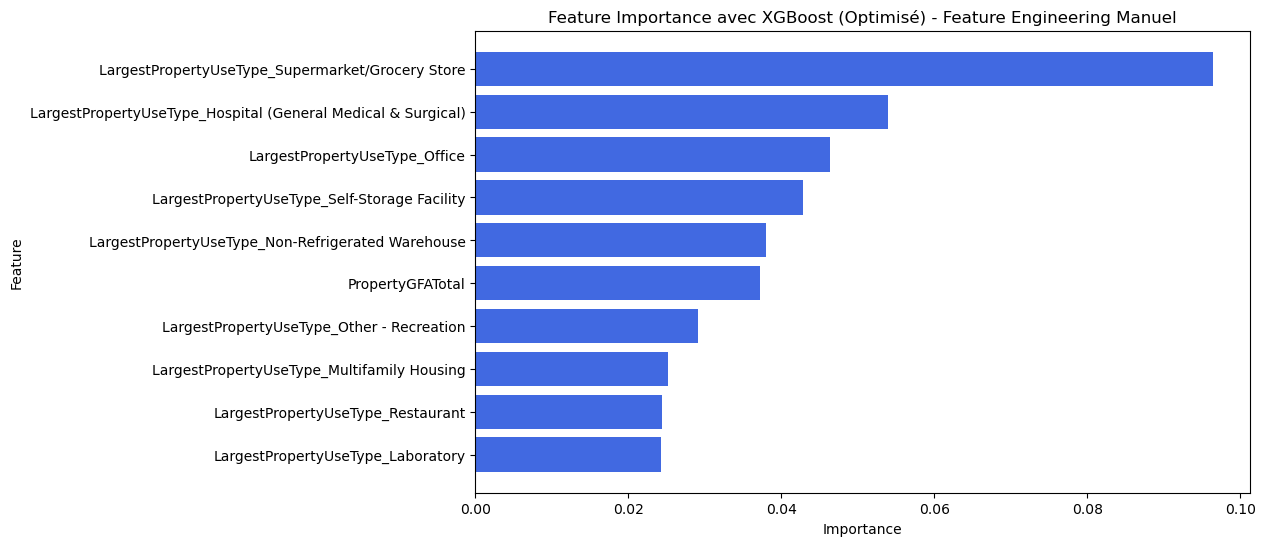

In [79]:
#Feature Importance globale
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer

import matplotlib.pyplot as plt
import pandas as pd

# Transformation des données avec le préprocesseur
X_train_transformed = preprocessor_manuel.fit_transform(X_train)
X_test_transformed = preprocessor_manuel.transform(X_test)  # Utilisez transform() sur X_test pour éviter la divergence

#Sélection des features numériques et catégorielles
num_features = X_train.select_dtypes(include=['number']).columns
cat_features = X_train.select_dtypes(include=['object']).columns

#Définition du préprocesseur avec StandardScaler pour les features numériques + OneHotEncoder pour les catégorielles
preprocessor_manuel = ColumnTransformer([
    ('quanti', StandardScaler(), num_features),  # Normalisation des variables numériques
    ('quali', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_features)  # Encodage des variables catégorielles
])

#Transformation des données
X_train_transformed = preprocessor_manuel.fit_transform(X_train)
X_test_transformed = preprocessor_manuel.transform(X_test)

#Extraction des noms des colonnes après transformation
num_feature_names = num_features  # Les colonnes numériques conservent leurs noms d'origine
cat_feature_names = preprocessor_manuel.named_transformers_['quali'].get_feature_names_out(cat_features)  # Colonnes après OneHot

#Fusionner tous les noms de colonnes
all_feature_names = np.concatenate([num_feature_names, cat_feature_names])

#Conversion en DataFrame avec les bons noms de colonnes
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=all_feature_names, index=X_train.index)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=all_feature_names, index=X_test.index)

#Vérification des dimensions
print(f"Dimensions de X_train_transformed_df : {X_train_transformed_df.shape}")
print(f"Dimensions de X_test_transformed_df : {X_test_transformed_df.shape}")

#Initialisation et entraînement du modèle XGBoost avec les meilleures hyperparamètres
best_params = {
    "regressor__gamma": 0.25,
    "regressor__learning_rate": 0.06,
    "regressor__max_depth": 2,
    "regressor__n_estimators": 375,
    "random_state": 42
}

xgb_model = xgb.XGBRegressor(**best_params)
xgb_model.fit(X_train_transformed_df, y_train)

#Feature importance globale
feature_importances = xgb_model.feature_importances_

#Création d'un DataFrame pour afficher les importances
importances_df = pd.DataFrame({
    "Feature": X_train_transformed_df.columns,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

#Affichage des 10 features les plus importantes
plt.figure(figsize=(10, 6))
plt.barh(importances_df["Feature"][:10], importances_df["Importance"][:10], color="royalblue")
plt.gca().invert_yaxis()  # Afficher les plus importantes en haut
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance avec XGBoost (Optimisé) - Feature Engineering Manuel")
plt.show()

Analyse des résultats : 

- LargestPropertyUseType_Supermaket/Grocery Store est la variable la plus influente sur la prédiction de la consommation d'énergie. 
- PropertyGFATotal (surface total du bâtiment) a également un fort impact, logique, car la consommation énergétique est fortement liée à la taille du bâtiment.
- Plusieurs types d'utilisation du bâtiments sont déterminant (Office, hospital, restaurant)
- Les ratios de surface ont moins d'importance. 

Bâtiment 529 - Consommation d'énergie prédit :  3.73 kBtu
 Waterfall Plot :


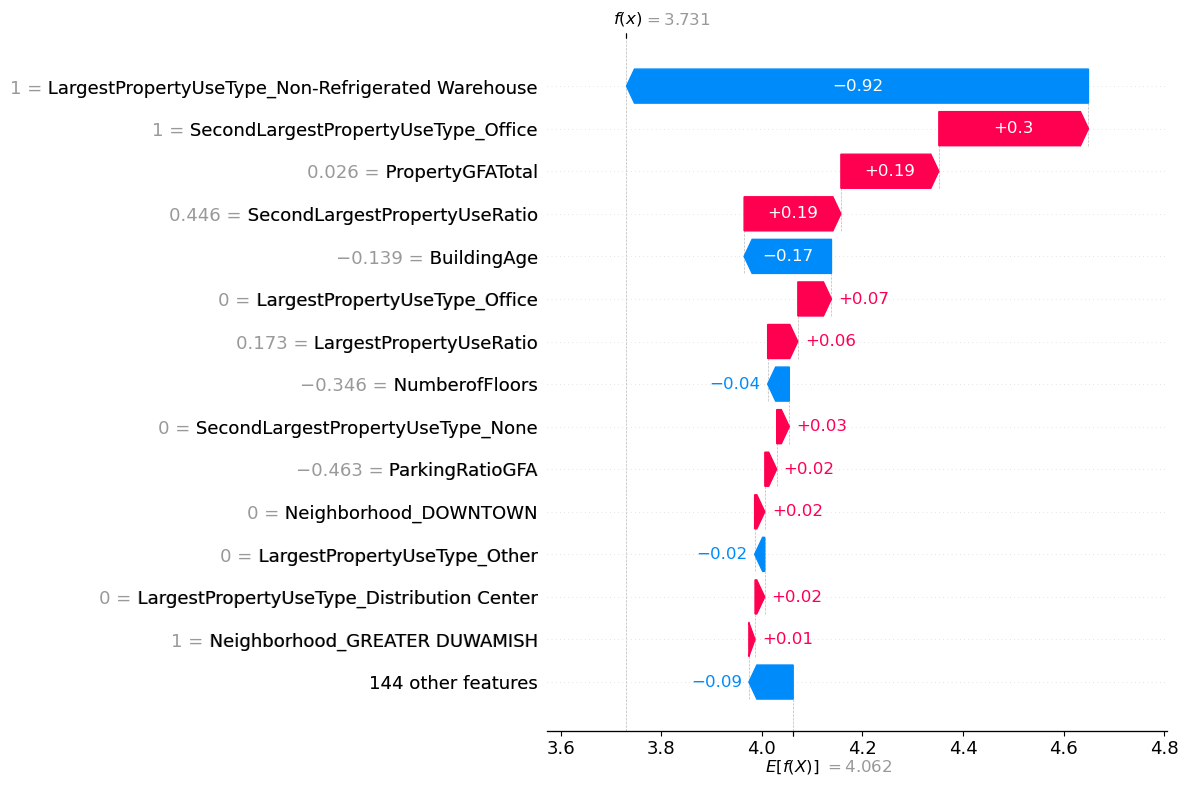

 Force plot :


In [80]:
import shap

#Sélection d'un bâtiment
X_local_1 = X_test_transformed_df.loc[[529]] #Index 529
y_pred_1 = xgb_model.predict(X_local_1)

#Affichage de la préd
batiment_id = X_local_1.index[0]
print(f"Bâtiment {batiment_id} - Consommation d'énergie prédit : {y_pred_1[0]: .2f} kBtu")

#Initialiser l'explainer SHAP
explainer = shap.Explainer(xgb_model, X_train_transformed_df)
shap_values_1 = explainer(X_local_1)

#Waterfall plot
print(" Waterfall Plot :")
shap.plots.waterfall(shap_values_1[0], max_display=15)

#Force plot
print(" Force plot :")
shap.initjs()
shap.plots.force(shap_values_1[0])

Analyse graphique pour le bâtiment 529 (prédiction de 3.73 Kbtu) :

Facteurs réducteurs majeurs:

- LargestPropertyUseType_Non-Refrigerated Warehouse (-0.92) : L'usage principal en tant qu'entrepôt non réfrigéré réduit significativement la consommation d'énergie.
- BuildingAge (-0.17) : Un âge de bâtiment plus élevé réduit la consommation, ce qui est inhabituel mais pourrait être dû à des rénovations ou des améliorations énergétiques.
- NumberofFloors (-0.04) : Un nombre élevé d'étages réduit légèrement la consommation.

Facteurs amplificateurs:

- SecondLargestPropertyUseType_Office (+0.30) : L'usage secondaire en tant que bureau augmente la consommation d'énergie.
- PropertyGFATotal (+0.19) : Une grande surface totale augmente la consommation.
- SecondLargestPropertyUseRatio (+0.19) : Un ratio élevé d'usage secondaire augmente la consommation.
- Neighborhood_GREATER DUWAMISH (+0.01) : La localisation dans le quartier Greater Duwamish augmente légèrement la consommation.

Bâtiment 901 - Consommation d'énergie prédit :  3.81 kBtu
 Waterfall Plot :


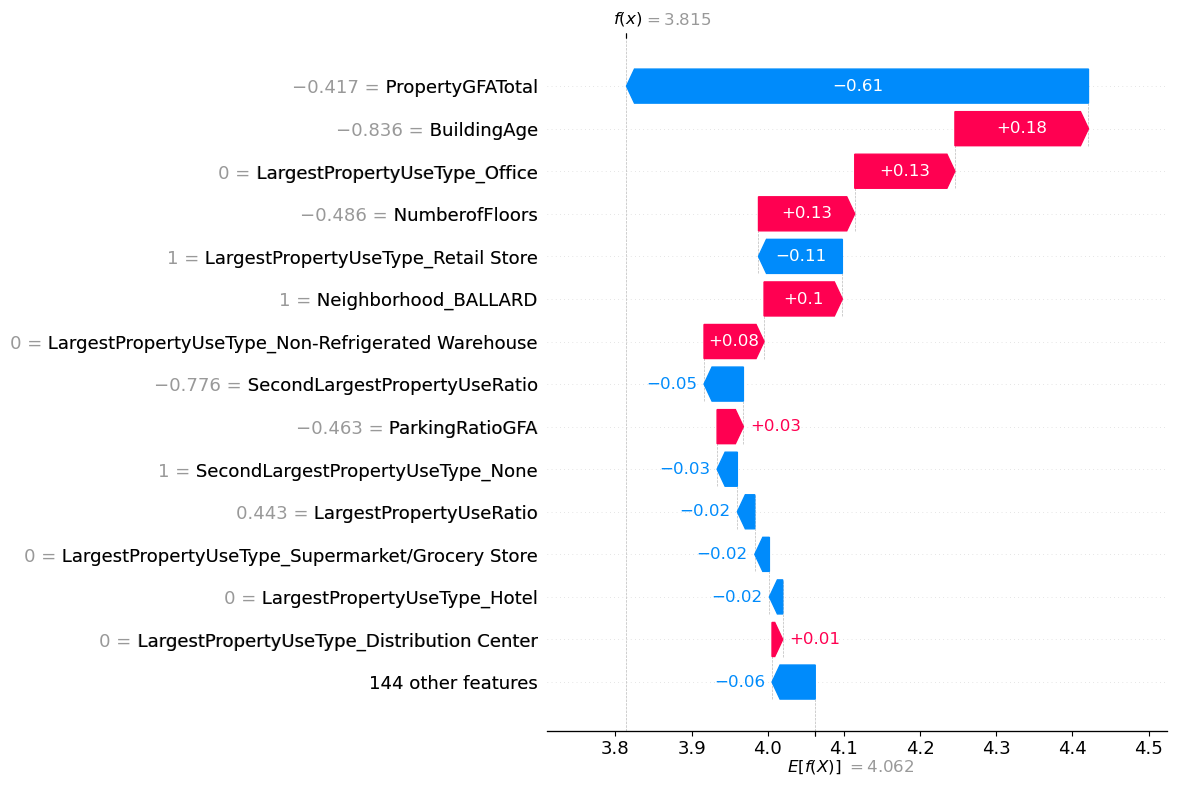

 Force plot :


In [81]:
#Sélection d'un bâtiment
X_local_2 = X_test_transformed_df.loc[[901]] #Index 772
y_pred_2 = xgb_model.predict(X_local_2)

#Affichage de la préd
batiment_id = X_local_2.index[0]
print(f"Bâtiment {batiment_id} - Consommation d'énergie prédit : {y_pred_2[0]: .2f} kBtu")

#Initialiser l'explainer SHAP
explainer = shap.Explainer(xgb_model, X_train_transformed_df)
shap_values_2 = explainer(X_local_2)

#Waterfall plot
print(" Waterfall Plot :")
shap.plots.waterfall(shap_values_2[0], max_display=15)

#Force plot
print(" Force plot :")
shap.initjs()
shap.plots.force(shap_values_2[0])

Analyse graphique pour le bâtiment 901 (prédiction de 3.81 Kbtu) :

Facteurs réducteurs majeurs:

- PropertyGFATotal (-0.61): une grande surface totale réduit la consommation d'énergie
- NumberofFloors (-0.49): Un nombre d'étage élevé réduit la consommation d'énergie

Facteur amplificateur:

- BuildingAge (+0.18) : Un âge de bâtiment plus élevé augmente la consommation.
- LargestPropertyUseType_Office (+0.13) : L'usage principal en tant que bureau augmente la consommation.
- Neighborhood_BALLARD (+0.10) : La localisation dans le quartier Ballard augmente la consommation.

Bâtiment 772 - Consommation d'énergie prédit :  2.78 kBtu
 Waterfall Plot :


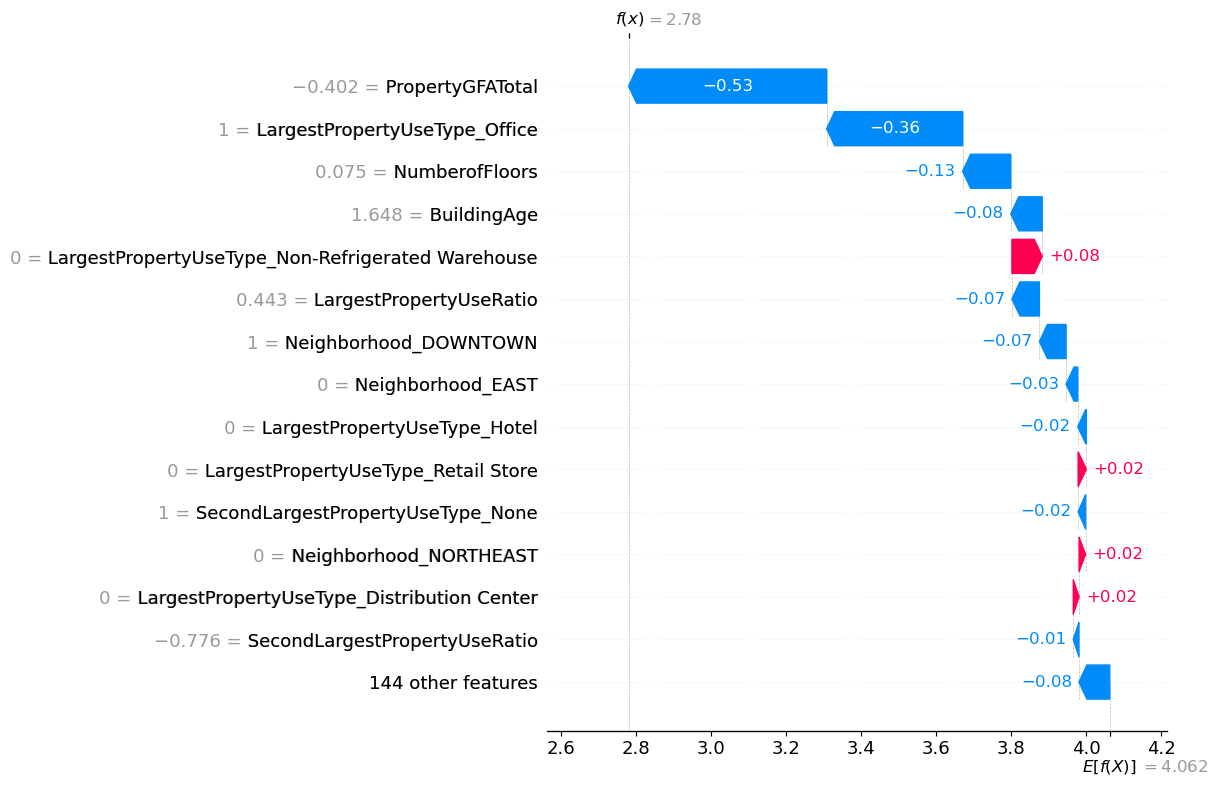

 Force plot :


In [82]:
#Sélection d'un bâtiment
X_local_3 = X_test_transformed_df.loc[[772]] #Index 772
y_pred_3 = xgb_model.predict(X_local_3)

#Affichage de la préd
batiment_id = X_local_3.index[0]
print(f"Bâtiment {batiment_id} - Consommation d'énergie prédit : {y_pred_3[0]: .2f} kBtu")

#Initialiser l'explainer SHAP
explainer = shap.Explainer(xgb_model, X_train_transformed_df)
shap_values_3 = explainer(X_local_3)

#Waterfall plot
print(" Waterfall Plot :")
shap.plots.waterfall(shap_values_3[0], max_display=15)

#Force plot
print(" Force plot :")
shap.initjs()
shap.plots.force(shap_values_3[0])

Analyse graphique pour le bâtiment 772 (prédiction de 2.78 Kbtu) :

Facteurs réducteurs majeurs:

- PropertyGFATotal (-0.53) : une grande surface totale réduit la consommation d'énergie
- LargestPropertyUseType_Office (-0.36) : L'usage principal en tant que bureau réduit la consommation
- NumberOfFloors (-0.13): Un nombre élevé d'étages réduit également la consommation

Facteur amplificateur:

- LargestPropertyUseType_Non-Refrigerated Warehouse (+0.08) : L'usage en tant qu'entrepôt non réfrigéré augmente légèrement la consommation 
- Neighborhood_NORTHEAST (+0.02) : La localisation dans le quartier (ici Nord-Est) augmente la consommation d'énergie

***Conclusion:***

- La taille du bâtiment à souvent un effet réducteur sur la consommation d'énergie, surtout pour les grandes surfaces.
- Âge du bâtiment peut jouer dans les deux sens, les bâtiments plus anciens ont tendance à consommer plus d'énergie, dû à l'inefficacité énergitique.
- Type d'usage principal est déterminant, les entrepôts non réfrigérés consomment généralement moins d'énergie, tandis que d'autres types de bâtiments (commerces ou bureaux) peuvent influencer différemment la consommation
- La localisation est également un facteur important, certains quartiers sont associés à des consommations d'énergies plus élevèes, cela peut être dû à la différence d'équipement du quartier ou des infra locales.


## Impact Energy Star Score

In [83]:
#Copie les données et prépare X et y
X_ESS = data.copy().drop(['OSEBuildingID','SiteEnergyUse(kBtu)','TotalGHGEmissions'],axis=1)
y_ESS = data.copy()['TotalGHGEmissions'] 

In [84]:
#Séparer train/test AVANT de supprimer les NaN
X_train_ESS, X_test_ESS, y_train_ESS, y_test_ESS = train_test_split(X_ESS, y_ESS, test_size=0.2, random_state=42)

In [85]:
#Calcul de la médiane sur le train uniquement pour éviter la fuite de données
median_score = X_train_ESS['ENERGYSTARScore'].median()

#Remplacement des NaN par la médiane pour éviter la fuite de données
X_train_ESS['ENERGYSTARScore'].fillna(median_score, inplace=True)
X_test_ESS['ENERGYSTARScore'].fillna(median_score, inplace=True)

#je remplace au lieu de supprimer, pour garder plus d'échantillons, pas de perte de structure, limite le sur-apprentissage.

#Supprimer les lignes ou 'ENERGYSTARScore' est NaN
#X_train_ESS = X_train_ESS.dropna(subset=['ENERGYSTARScore'])
#X_test_ESS = X_test_ESS.dropna(subset=['ENERGYSTARScore'])

In [86]:
#Remplacer les valeurs inf à 0 par une médiane
y_train_ESS[y_train_ESS <= 0] = y_train_ESS.median()

In [87]:
#Ajouter y_train et y_test pour garder les bons indices
y_train_ESS = y_train_ESS.loc[X_train_ESS.index]
y_test_ESS = y_test_ESS.loc[X_test_ESS.index]

In [88]:
#Appliquer la transformation
#X_train_ESS = compute_surface_ratios(X_train_ESS)
#X_test_ESS = compute_surface_ratios(X_test_ESS)

In [89]:
#Séparer les features quantitatives et qualitatives
quanti_ESS = X_train_ESS.select_dtypes(include=['int32', 'float64']).columns
quali_ESS = X_train_ESS.select_dtypes(include=['category', 'object', 'bool']).columns

In [90]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer

#Création du préprocesseur avec 'FunctionTransformer' pour le feature engineering
preprocessor_manuel = ColumnTransformer([
    ('quanti', StandardScaler(), quanti_ESS),  #Normalisatddion des colonnes numériques
    ('quali', OneHotEncoder(handle_unknown='ignore', sparse=False), quali_ESS)  # Encodage des colonnes catégoriques
], remainder='passthrough')  # Garde les autres colonnes

In [91]:
#Définition du modèle XGBoost avec les meilleurs hyperparamètres
xgb_model = XGBRegressor(
    gamma=0.03, 
    learning_rate=0.05, 
    max_depth=3,  
    n_estimators=500, 
    random_state=42
)

#Création du pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor_manuel),
    ('regressor', xgb_model)
])

#Entraînement du pipeline
pipeline.fit(X_train_ESS, y_train_ESS)

#Évaluation du modèle
train_score = pipeline.score(X_train_ESS, y_train_ESS)
test_score = pipeline.score(X_test_ESS, y_test_ESS)

print(f"🔹 Score sur l'entraînement: {train_score:.3f}")
print(f"🔹 Score sur le test: {test_score:.3f}")

#Prédictions et calcul du RMSE
y_pred = pipeline.predict(X_test_ESS)
rmse = np.sqrt(mean_squared_error(y_test_ESS, y_pred))
print(f"📉 RMSE sur le test: {rmse:.2f}")

🔹 Score sur l'entraînement: 0.981
🔹 Score sur le test: 0.493
📉 RMSE sur le test: 792.57


Analyse des résultats:

- Score de l'entraînement (0.986): le modèle est capable d’expliquer 98,1 % de la variance sur les données d’entraînement. C’est un très bon score qui indique que le modèle parvient à bien apprendre les relations dans les données.
- Score sur le test (0.493): le score sur les données de test est nettement plus bas. Cela montre que le modèle a des difficultés à généraliser à de nouvelles données. Il a probablement capturé des relations spécifiques aux données d’entraînement, ce qui le rend moins performant pour prédire sur des bâtiments qu’il n’a jamais vus.
- RMSE (792.57): erreur quadratique moyenne sur le test est de 792.57, ce qui indique une erreur de prédiction encore significative. Cela confirme que les prédictions du modèle peuvent être éloignées de la réalité sur certains bâtiments, notamment si ceux-ci présentent des caractéristiques moins fréquentes ou mal représentées dans les données d’entraînement.

## Conclusion

Résumé:

- Modèle XGBoost avec une transformation manuelle des données et préprocessing semble être une bonne approche pertinente pour prédire la consommation d'énergie. Le score élevé sur les données d'entraînement témoigne une capacité du modèle à apprendre les relations présentes dans les données.
- Cependant, le score plus modeste sur les données de test (0.493) et une RMSE de 792.57 révèlent une généralisation limitée : le modèle parvient à bien s'ajuster sur les données qu'il a vues, mais il a du mal à faire des prédictions précises sur de nouveaux bâtiments.

Axes d'améliorations:

- Affiner les hyperparamètres : pour encore plus pousser les performances, explorer d'avantages les hyperparamètres du modèle.
- Utiliser une validation croisée pour avoir une évalution plus robuste du modèle.
- Réduire complexité du modèle
- Exploiter d'autres modèles 